In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler#, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer, accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('emails.csv')
df = df.drop(columns=['Email No.'])
X= df.drop(columns=['Prediction', 'enron', 'hpl'])
y= df['Prediction']

In [18]:
def run_cl_sc_sm(X, y, classifier, sc, split_method, rs, weighted=False, cl_weh=None, apply_smote=False):
    
    split_dc = {
        'skf': StratifiedKFold(n_splits=5, shuffle=True, random_state=rs),
        'sss': StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=rs),
        'kf': KFold(n_splits=5, shuffle=True, random_state=rs)
    }
    
    if split_method == 'tt':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
    elif split_method in split_dc.keys():
        for train_index, test_index in split_dc[split_method].split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    else:
        print(split_method + ' not allowed')
        return None
    
    if apply_smote:
        smote = SMOTE(random_state=rs)
        X_train, y_train = smote.fit_resample(X_train, y_train)   
    
    if sc:
        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)
        
    if weighted: 

        if isinstance(classifier, CatBoostClassifier):
            try: 
                classifier = CatBoostClassifier(**classifier.get_params(), class_weights = list(cl_weh.values()))
            except Exception as e:
                    print(f"Error applying class_weights to CatBoostClassifier: {e}")

        elif hasattr(classifier, 'class_weight'):
            try:
                classifier.set_params(class_weight=cl_weh)   
            except Exception as e:
                print(f"Error applying class_weight: {e} ")
    
    classifier.fit(X_train, y_train)

    y_pred_test = classifier.predict(X_test)
    y_pred_proba_test = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else None

    y_pred_train = classifier.predict(X_train)
    y_pred_proba_train = classifier.predict_proba(X_train)[:, 1] if hasattr(classifier, 'predict_proba') else None
    
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_test) if y_pred_proba_test is not None else 'N/A',       
        'tp': tp_test,
        'tn': tn_test,
        'fp': fp_test,
        'fn': fn_test,
    }
    
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()

    # Metrics for train set
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train),
        'recall': recall_score(y_train, y_pred_train),
        'f1': f1_score(y_train, y_pred_train),
        'roc_auc': roc_auc_score(y_train, y_pred_proba_train) if y_pred_proba_train is not None else 'N/A',        
        'tp': tp_train,
        'tn': tn_train,
        'fp': fp_train,
        'fn': fn_train,
        
    }

    # Precision-recall and ROC curves for test set
    if y_pred_proba_test is not None:
        # Precision-recall curve for class 1 (default behavior)
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
        ap_score = average_precision_score(y_test, y_pred_proba_test)
        test_metrics.update({
            'precision_recall_class_1': (precision, recall, thresholds),
            'average_precision_class_1': ap_score
        })
        
        # ROC curve for class 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba_test)
        roc_auc = roc_auc_score(y_test, y_pred_proba_test)   
        test_metrics.update({
            'roc_curve_class_1': (fpr, tpr, roc_thresholds),
            'roc_auc_class_1': roc_auc
        })

        # Invert labels to calculate precision-recall for class 0
        y_test_inverted = np.where(y_test == 0, 1, 0)
        precision_0, recall_0, thresholds_0 = precision_recall_curve(y_test_inverted, 1 - y_pred_proba_test)
        ap_score_0 = average_precision_score(y_test_inverted, 1 - y_pred_proba_test)
        test_metrics.update({
            'precision_recall_class_0': (precision_0, recall_0, thresholds_0),
            'average_precision_class_0': ap_score_0
        })

    if y_pred_proba_train is not None:
        precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_proba_train)
        ap_score_train = average_precision_score(y_train, y_pred_proba_train)
        train_metrics.update({
            'precision_recall': (precision_train, recall_train, thresholds_train),
            'average_precision': ap_score_train
        })
        
        fpr_train, tpr_train, roc_thresholds_train = roc_curve(y_train, y_pred_proba_train)
        roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)   
        train_metrics.update({
            'roc_curve': (fpr_train, tpr_train, roc_thresholds_train),
            'roc_auc': roc_auc_train
        })

        # Invert labels for training set to calculate precision-recall for class 0
        y_train_inverted = np.where(y_train == 0, 1, 0)
        precision_train_0, recall_train_0, thresholds_train_0 = precision_recall_curve(y_train_inverted, 1 - y_pred_proba_train)
        ap_score_train_0 = average_precision_score(y_train_inverted, 1 - y_pred_proba_train)
        train_metrics.update({
            'precision_recall_class_0': (precision_train_0, recall_train_0, thresholds_train_0),
            'average_precision_class_0': ap_score_train_0
        })
        
    return {'train_metrics': train_metrics, 'test_metrics': test_metrics} 

In [23]:
metrics1 = {}

classifiers = {
    'LGBM': LGBMClassifier(verbose=0),
    'CatBoost':CatBoostClassifier(silent=True),
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest150': RandomForestClassifier(n_estimators=150)
}

for c_name, classifier in classifiers.items():
    for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
        for split_method in ['tt', 'sss', 'skf']:
            for bool_smote in [True, False]:
                
                smote_str = '_smote' if bool_smote else '_unsmote'
                    
                for bool_wh in [True, False]:
                    
                    wh_str = '_weighted' if bool_wh else '_unweighted'
                    cl_wh = {0: 1, 1: 1.28} if bool_wh else None
                                            
                    scores = run_cl_sc_sm(X, y, classifier, sc, split_method, 31,
                                apply_smote=bool_smote, weighted=bool_wh, cl_weh=cl_wh)
                    
                    key = f"{c_name}_{split_method}_{sc.__class__.__name__}{smote_str}{wh_str}"
                    
                    if key not in metrics1:
                        metrics1[key] = {}

                    metrics1[key].update(scores)

In [28]:
train_m1 = {}
test_m1 = {}

for k in metrics1.keys():
    train_m1[k] = metrics1[k]['train_metrics']
    test_m1[k] = metrics1[k]['test_metrics']
       

train_df = pd.DataFrame.from_dict(train_m1, orient='index').sort_values(by=['fp', 'f1']).reset_index()
train_df[['model', 'split_method', 'scaler', 'smote', 'weighted']] = train_df['index'].str.split('_', expand=True) 
train_df = train_df.set_index('index')

results_df = pd.DataFrame.from_dict(test_m1, orient='index').sort_values(by=['fp', 'f1']).reset_index()
results_df[['model', 'split_method', 'scaler', 'smote', 'weighted']] = results_df['index'].str.split('_', expand=True) 
results_df = results_df.set_index('index')

In [40]:
#results_df.to_csv('new_test.csv')
#train_df.to_csv('new_train.csv')

In [43]:
results_df.weighted.unique()

array(['unweighted', 'weighted'], dtype=object)

In [48]:

# return 4 dataframes with 4 combinatinos of if smote as applied (smote, unsmote) and if weights were applied (weighted, unweighted)
def smote_weighted_4df(df):
    
    smote_filter = df['smote'] == 'smote'
    weight_filter = df['weighted'] == 'weighted'
    
    smote_weighted = df[smote_filter & weight_filter]  # SMOTE and weighted
    smote_unweighted = df[smote_filter & ~weight_filter]  # SMOTE and unweighted
    unsmote_weighted = df[~smote_filter & weight_filter]  # Unsmote and weighted
    unsmote_unweighted = df[~smote_filter & ~weight_filter]  # Unsmote and unweighted
    
    return smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted

In [49]:
smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted = smote_weighted_4df(results_df)

In [50]:
tr_smote_weighted, tr_smote_unweighted, tr_unsmote_weighted, tr_unsmote_unweighted = smote_weighted_4df(train_df)

In [51]:
def get_aggregate_df(df, agg_dc, group_col):
    return df.groupby(group_col).agg(agg_dc).reset_index().set_index(group_col)

metric_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'fp', 'fn', 'tp', 'tn']
metric_mean_dc = {k:'mean' for k in metric_cols}

In [54]:
def get_aggs(smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted, metric_mean_dc, group_col):
    model_uu = get_aggregate_df(unsmote_unweighted, metric_mean_dc, group_col)
    model_su = get_aggregate_df(smote_unweighted, metric_mean_dc, group_col)
    model_uw = get_aggregate_df(unsmote_weighted, metric_mean_dc, group_col)
    model_sw = get_aggregate_df(smote_weighted, metric_mean_dc, group_col)   
    
    return model_sw, model_su, model_uw, model_uu

In [170]:
import seaborn as sns 
def plot_metric(train_df, test_df, model_col='model', metric_col='precision', title_appendage = ': Train vs. Test', fig=(14, 6), bar_min=0, bar_max=1, loc='lower right'):
    train_filtered = train_df[[model_col, metric_col]].copy()
    test_filtered = test_df[[model_col, metric_col]].copy()

    train_filtered.loc[:, 'dataset'] = 'train'
    test_filtered.loc[:, 'dataset'] = 'test'

    combined_df = pd.concat([train_filtered, test_filtered]).sort_values(by=model_col)
    combined_df.columns = [model_col, metric_col, 'dataset']
    combined_df = combined_df.sort_values(by=metric_col, ascending=False)
    
    custom_palette = ['#1f77b4', '#ff7f0e']

    plt.figure(figsize=fig)
    ax = sns.barplot(x=model_col, y=metric_col, hue='dataset', data=combined_df, 
                     errorbar=None, palette=custom_palette)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge')

    plt.title(model_col + ' ' + metric_col + title_appendage)
    plt.ylabel(metric_col)
    plt.xlabel(model_col)
    plt.ylim(bottom=bar_min, top=bar_max)
    plt.xticks(rotation=45)
    plt.legend(loc=loc)
    plt.tight_layout()
    plt.show()

In [56]:
model_sw, model_su, model_uw, model_uu = get_aggs(smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted, 
                                    metric_mean_dc, 'model')
scaler_sw, scaler_su, scaler_uw, scaler_uu = get_aggs(smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted, 
                                    metric_mean_dc, 'scaler')
split_sw, split_su, split_uw, split_uu = get_aggs(smote_weighted, smote_unweighted, unsmote_weighted, unsmote_unweighted, 
                                    metric_mean_dc, 'split_method')

In [59]:
tr_model_sw, tr_model_su, tr_model_uw, tr_model_uu = get_aggs(tr_smote_weighted, tr_smote_unweighted, tr_unsmote_weighted, tr_unsmote_unweighted, 
                                    metric_mean_dc, 'model')

tr_scaler_sw, tr_scaler_su, tr_scaler_uw, tr_scaler_uu = get_aggs(tr_smote_weighted, tr_smote_unweighted, tr_unsmote_weighted, tr_unsmote_unweighted, 
                                    metric_mean_dc, 'scaler')

tr_split_sw, tr_split_su, tr_split_uw, tr_split_uu = get_aggs(tr_smote_weighted, tr_smote_unweighted, tr_unsmote_weighted, tr_unsmote_unweighted, 
                                    metric_mean_dc, 'split_method')

In [211]:
model_diffs_sw_su = model_sw - model_su
scaler_diffs_sw_su = scaler_sw - scaler_su
split_diffs_sw_su = split_sw - split_su

model_diffs_uw_uu = model_uw - model_uu
scaler_diffs_uw_uu = scaler_uw - scaler_uu
split_diffs_uw_uu = split_uw - split_uu

In [209]:
model_diffs_su_uu = model_su - model_uu
scaler_diffs_su_uu = scaler_su - scaler_uu
split_diffs_su_uu = split_su - split_uu

model_diffs_sw_uw = model_sw - model_uw
scaler_diffs_sw_uw = scaler_sw - scaler_uw
split_diffs_sw_uw = split_sw - split_uw

In [256]:
comp_cols = ['precision', 'recall', 'f1']
model_diffs_sw_su[comp_cols]

,accuracy,precision,recall,f1
model,,,,
CatBoost,-0.001933,-0.008341,0.003333,-0.002922
LGBM,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.000000,0.000000,0.000000,0.000000
RandomForest150,-0.001504,-0.003104,-0.001871,-0.002520


In [218]:
model_sw

,accuracy,precision,recall,f1,roc_auc,fp,fn,tp,tn
model,,,,,,,,,
CatBoost,0.969718,0.915079,0.986573,0.949448,0.997651,27.333333,4.000000,294.333333,709.000000
LGBM,0.979276,0.946337,0.983992,0.964762,0.997231,16.666667,4.777778,293.555556,719.666667
LogisticRegression,0.957690,0.888999,0.976177,0.930226,0.991032,36.666667,7.111111,291.222222,699.666667
RandomForest150,0.975730,0.935858,0.983239,0.958938,0.996114,20.111111,5.000000,293.333333,716.222222


In [219]:
model_su

,accuracy,precision,recall,f1,roc_auc,fp,fn,tp,tn
model,,,,,,,,,
CatBoost,0.971651,0.923420,0.983239,0.952370,0.997600,24.333333,5.000000,293.333333,712.000000
LGBM,0.979276,0.946337,0.983992,0.964762,0.997231,16.666667,4.777778,293.555556,719.666667
LogisticRegression,0.957690,0.888999,0.976177,0.930226,0.991032,36.666667,7.111111,291.222222,699.666667
RandomForest150,0.977234,0.938962,0.985110,0.961458,0.996197,19.111111,4.444444,293.888889,717.222222


# 1) SMOTE Models: adding Class Weights

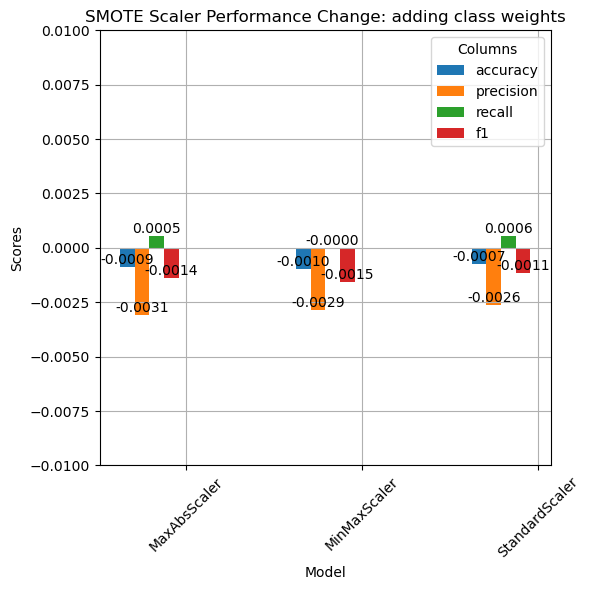

In [257]:
plot_bar_graphs(scaler_diffs_sw_su[comp_cols],
    columns=scaler_diffs_sw_su.columns,
    title='SMOTE Model Performance Change: adding class weights',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.01,  # Adjust these values if needed
    bar_max=0.01,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


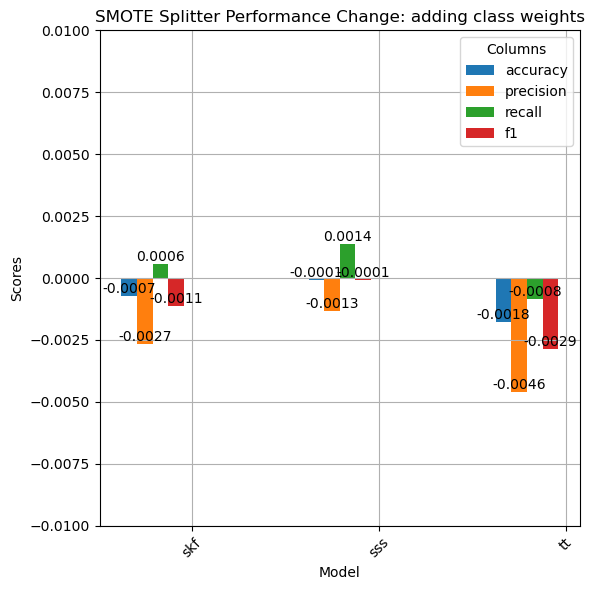

In [258]:
plot_bar_graphs(split_diffs_sw_su[comp_cols],
    columns=split_diffs_sw_su.columns,
    title='SMOTE Splitter Performance Change: adding class weights',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.01,  # Adjust these values if needed
    bar_max=0.01,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


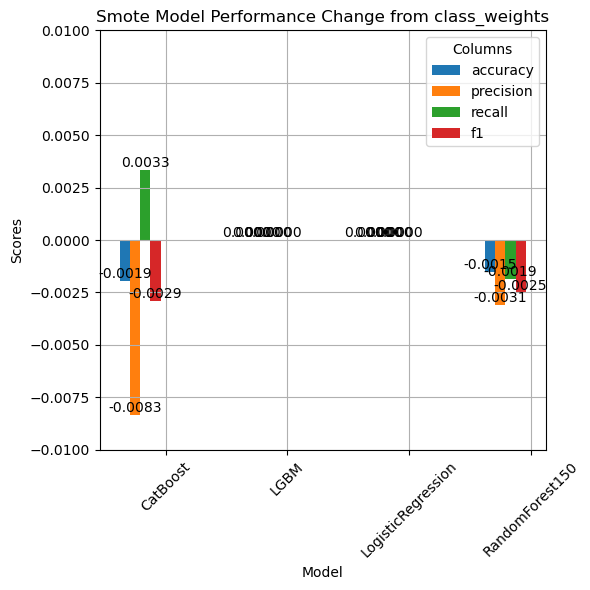

In [259]:
plot_bar_graphs(model_diffs_sw_su[comp_cols],
    columns=model_diffs_sw_su.columns,
    title='Smote Model Performance Change from class_weights',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.01,  # Adjust these values if needed
    bar_max=0.01,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


# 2) un-SMOTE Models: adding class_weights

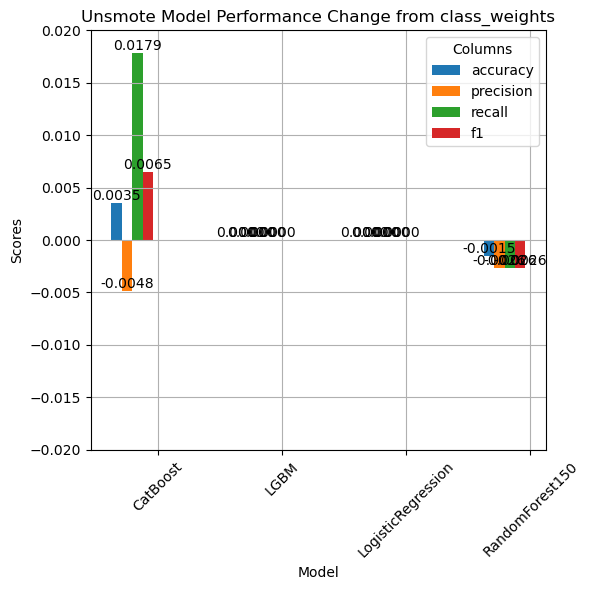

In [260]:
plot_bar_graphs(model_diffs_uw_uu[comp_cols],
    columns=model_diffs_uw_uu.columns,
    title='Unsmote Model Performance Change from class_weights',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.02,  # Adjust these values if needed
    bar_max=0.02,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


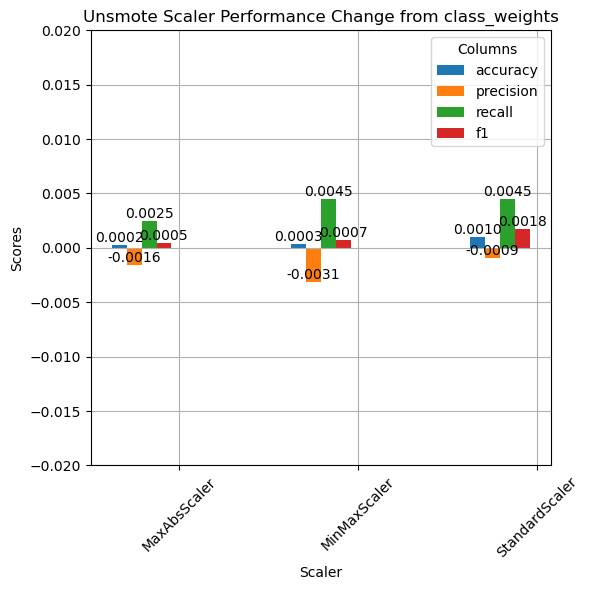

In [261]:
plot_bar_graphs(scaler_diffs_uw_uu[comp_cols],
    columns=scaler_diffs_uw_uu.columns,
    title='Unsmote Scaler Performance Change from class_weights',
    x_label='Scaler',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.02,  # Adjust these values if needed
    bar_max=0.02,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


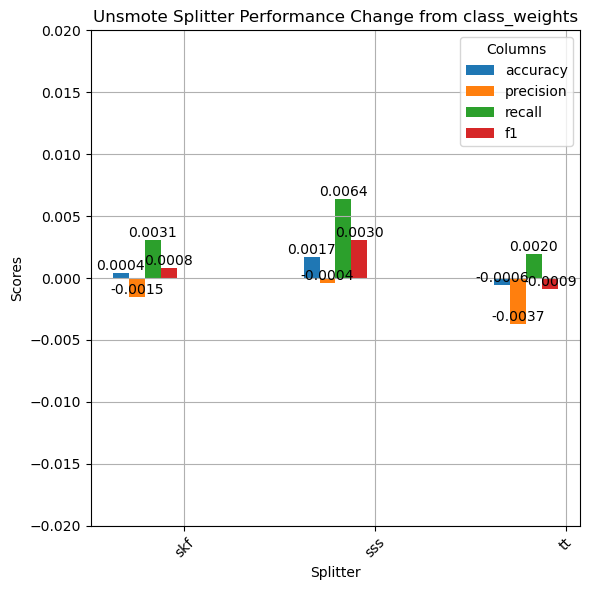

In [262]:
plot_bar_graphs(split_diffs_uw_uu[comp_cols],
    columns=split_diffs_uw_uu.columns,
    title='Unsmote Splitter Performance Change from class_weights',
    x_label='Splitter',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.02,  # Adjust these values if needed
    bar_max=0.02,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


# Weighted Models: Adding Smote

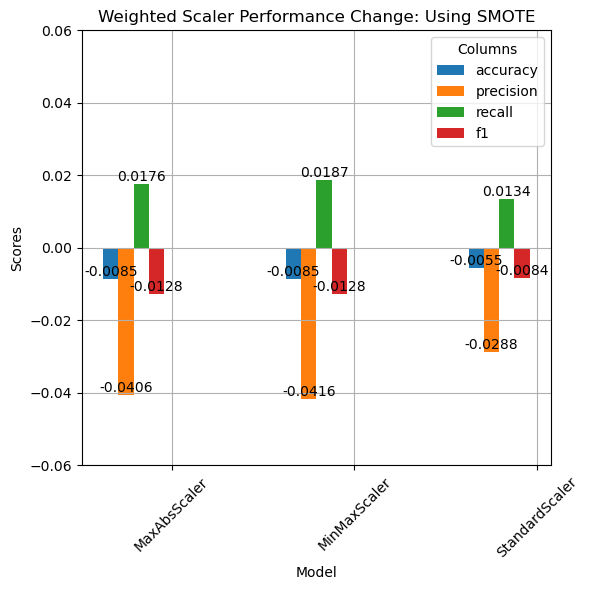

In [263]:
plot_bar_graphs(scaler_diffs_sw_uw[comp_cols],
    columns=scaler_diffs_sw_uw.columns,
    title='Weighted Scaler Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


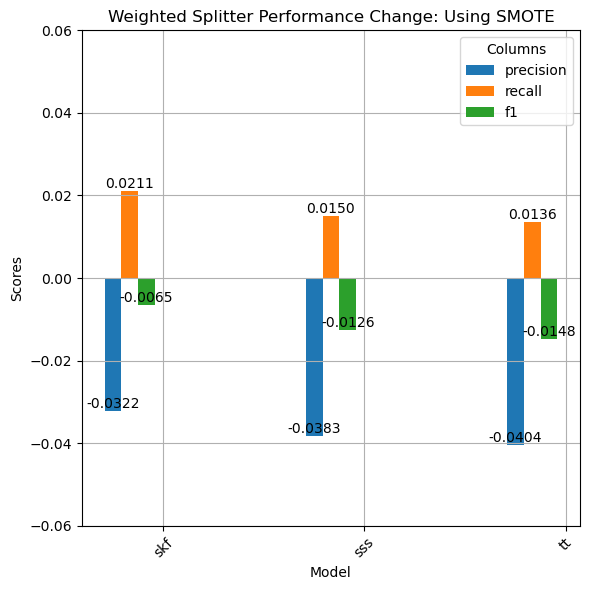

In [242]:
plot_bar_graphs(split_diffs_sw_uw[comp_cols],
    columns=split_diffs_sw_uw.columns,
    title='Weighted Splitter Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


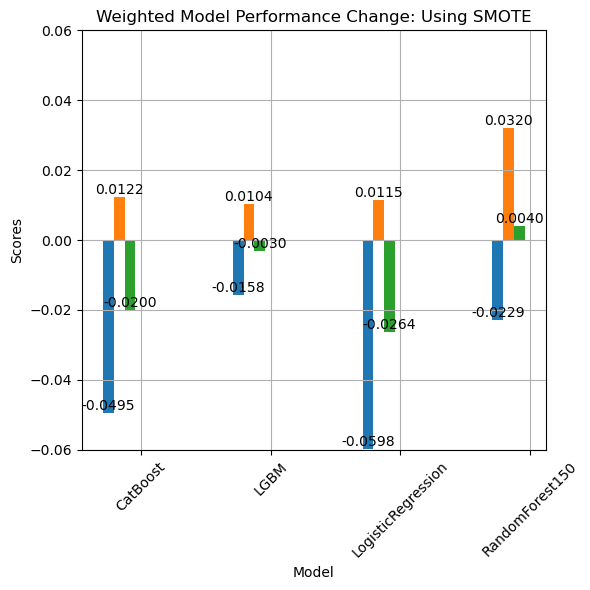

In [245]:
plot_bar_graphs(model_diffs_sw_uw[comp_cols],
    columns=model_diffs_sw_uw.columns,
    title='Weighted Model Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=False,
    grid=True,
    decimal=4
)


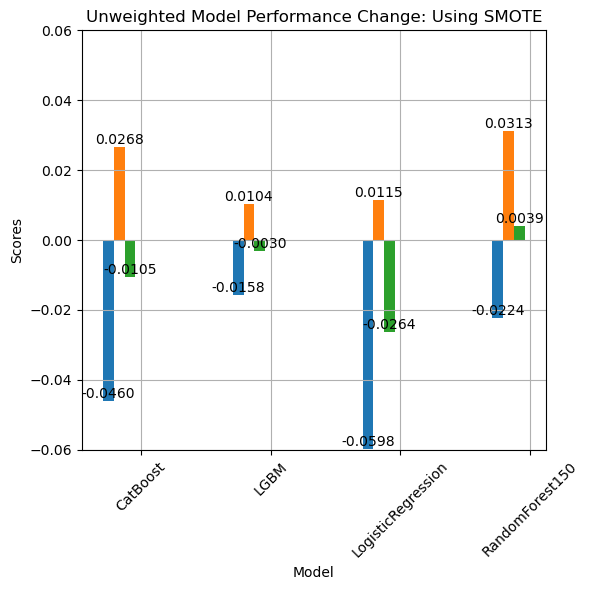

In [233]:
plot_bar_graphs(model_diffs_su_uu[comp_cols],
    columns=model_diffs_su_uu.columns,
    title='Unweighted Model Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=False,
    grid=True,
    decimal=4
)


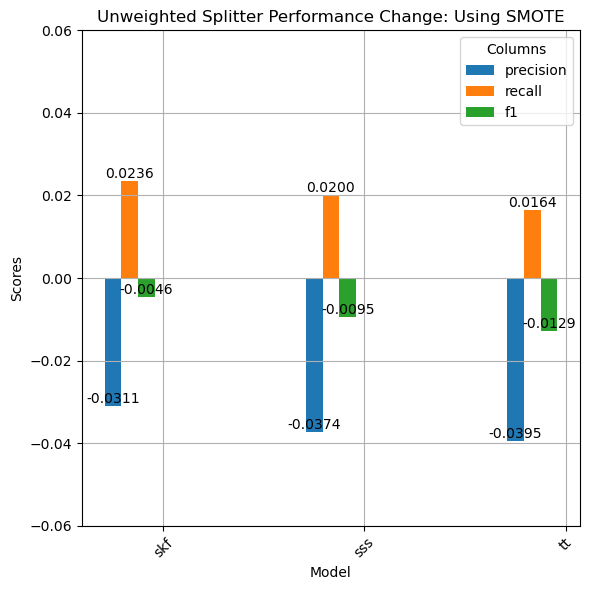

In [238]:
plot_bar_graphs(split_diffs_su_uu[comp_cols],
    columns=split_diffs_su_uu.columns,
    title='Unweighted Splitter Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


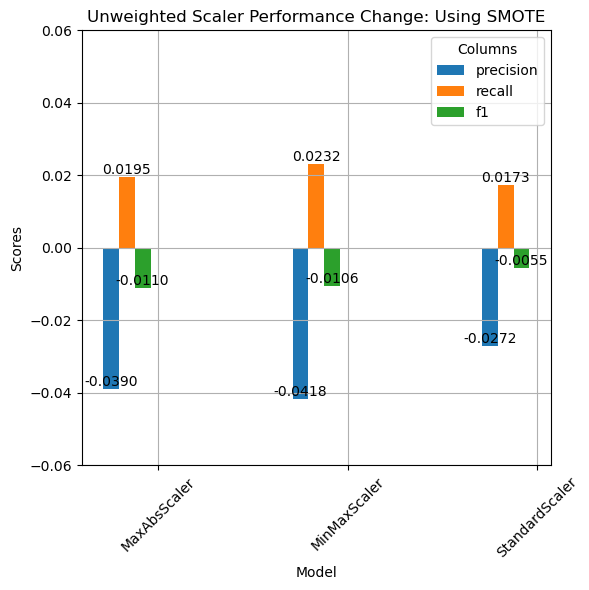

In [237]:
plot_bar_graphs(scaler_diffs_su_uu[comp_cols],
    columns=scaler_diffs_su_uu.columns,
    title='Unweighted Scaler Performance Change: Using SMOTE',
    x_label='Model',
    y_label='Scores',
    horizontal=False,  # Set to True if you prefer horizontal bars
    bar_min=-0.06,  # Adjust these values if needed
    bar_max=0.06,
    figsize=(6, 6),
    legend=True,
    grid=True,
    decimal=4
)


# 3) Smote Unweighted

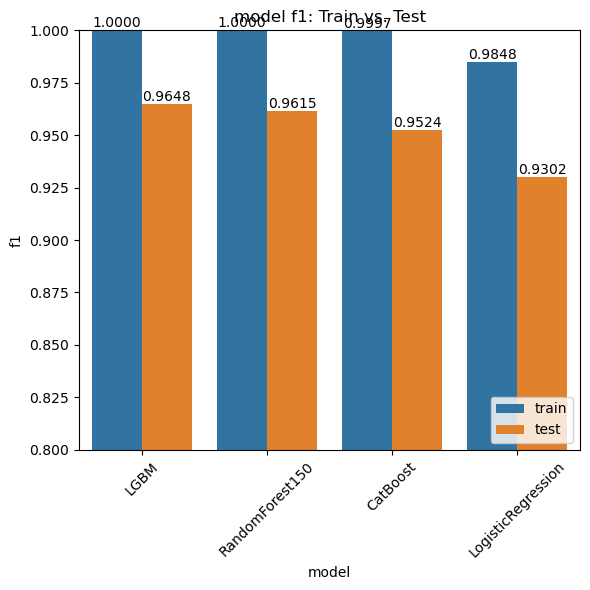

In [618]:
plot_metric(tr_model_su.reset_index(), model_su.reset_index(), 'model', metric_col='f1', fig=(6,6), bar_min=0.8)

# 2) UnSmote Weighted

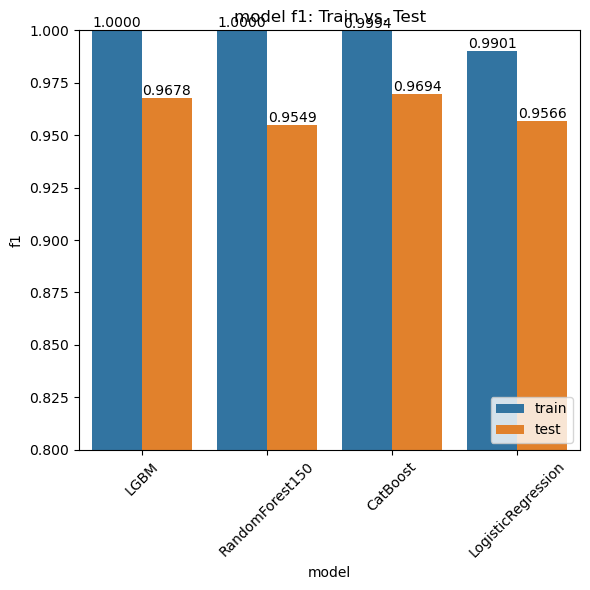

In [616]:
plot_metric(tr_model_uw.reset_index(), model_uw.reset_index(), 'model', metric_col='f1', fig=(6,6), bar_min=0.8)

# 1) Unsmote Unweighted

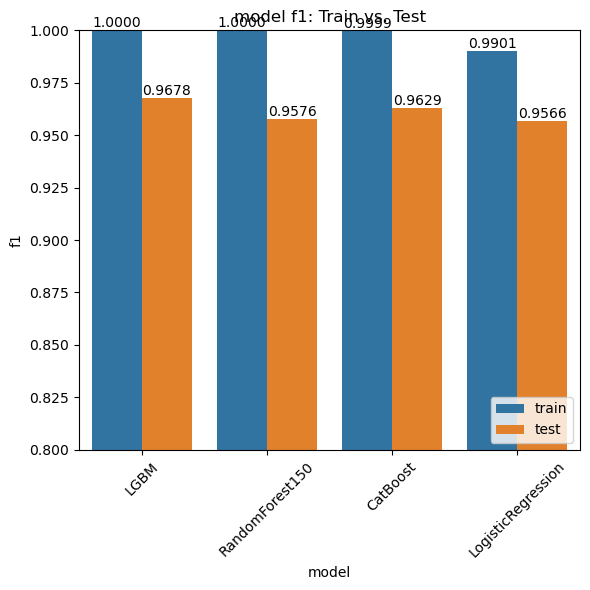

In [617]:
plot_metric(tr_model_uu.reset_index(), model_uu.reset_index(), 'model', metric_col='f1', fig=(6,6), bar_min=0.8)

# 4) Smote Weighted

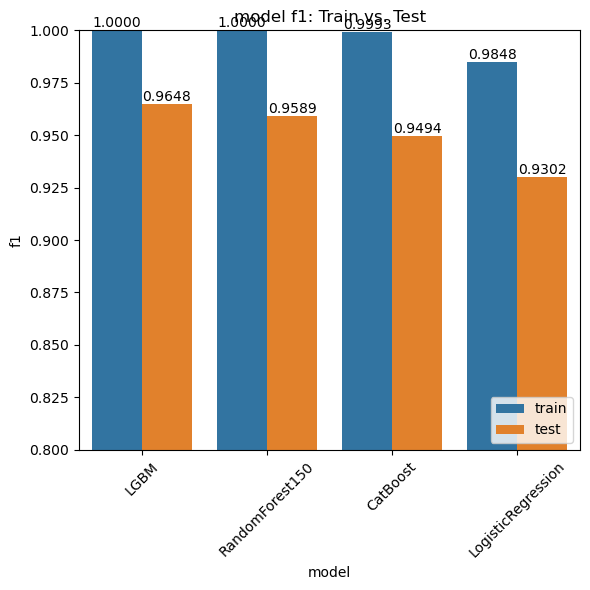

In [619]:
plot_metric(tr_model_sw.reset_index(), model_sw.reset_index(), 'model', metric_col='f1', fig=(6,6), bar_min=0.8)

# 3) Smote Unweighted

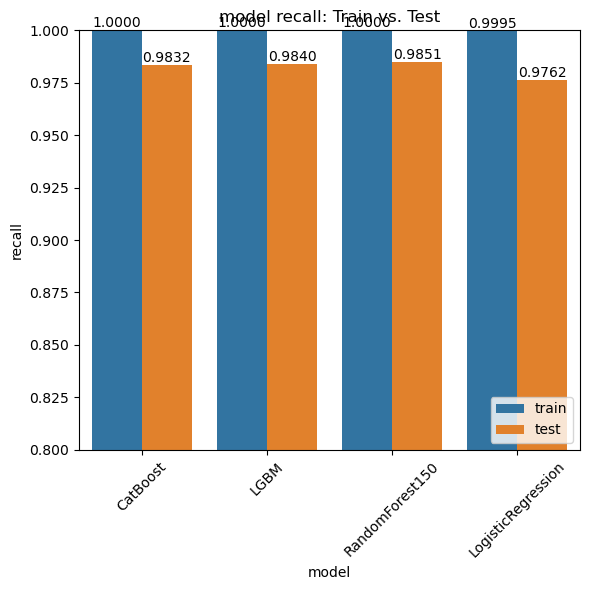

In [185]:
plot_metric(tr_model_su.reset_index(), model_su.reset_index(), 'model', metric_col='recall', fig=(6,6), bar_min=0.8)

# 4) Smote Weighted

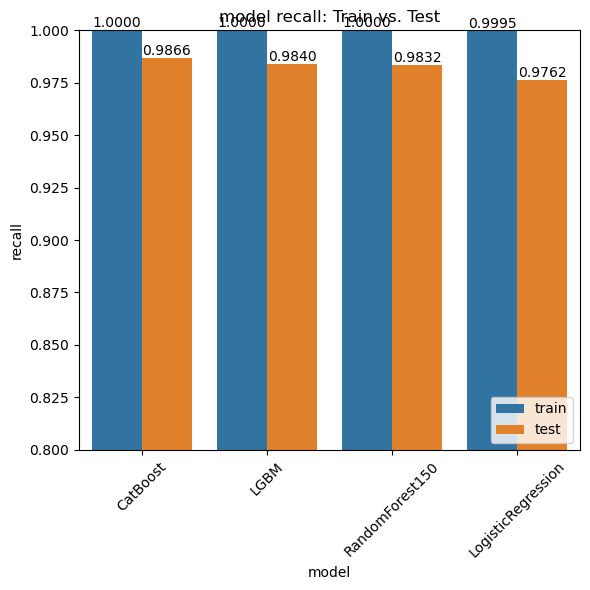

In [186]:
plot_metric(tr_model_sw.reset_index(), model_sw.reset_index(), 'model', metric_col='recall', fig=(6,6), bar_min=0.8)

In [311]:
roc_auc = ['CatBoost_skf_MinMaxScaler_smote_weighted', 'CatBoost_sss_MinMaxScaler_unsmote_weighted',
          'RandomForest150_skf_MaxAbsScaler_smote_unweighted','LGBM_sss_MinMaxScaler_unsmote_weighted',
           'LGBM_tt_MinMaxScaler_unsmote_weighted'
          'LGBM_skf_MinMaxScaler_unsmote_weighted','CatBoost_tt_MinMaxScaler_unsmote_weighted']

In [634]:
tops_df.sort_values(by='precision_at_recall_1', ascending=False)[['precision_at_recall_1', 'max_f1_score', 'optimal_threshold']].head(25)

,precision_at_recall_1,max_f1_score,optimal_threshold
model,,,
RandomForest150_tt_MinMaxScaler_smote_unweighted,0.921875,0.959350,0.493333
RandomForest150_tt_MinMaxScaler_smote_weighted,0.913313,0.958264,0.546667
RandomForest150_tt_MinMaxScaler_unsmote_unweighted,0.907692,0.969900,0.486667
RandomForest150_tt_MaxAbsScaler_unsmote_weighted,0.902141,0.965058,0.480000
RandomForest150_tt_MaxAbsScaler_smote_unweighted,0.899390,0.961857,0.513333
CatBoost_tt_StandardScaler_unsmote_unweighted,0.891239,0.969900,0.434900
RandomForest150_tt_StandardScaler_unsmote_unweighted,0.891239,0.959596,0.493333
CatBoost_tt_MinMaxScaler_unsmote_unweighted,0.891239,0.969900,0.434900
CatBoost_tt_MaxAbsScaler_unsmote_unweighted,0.891239,0.969900,0.434900


In [635]:
cb_lr1 = ['RandomForest150_tt_MinMaxScaler_smote_unweighted', 'CatBoost_tt_StandardScaler_unsmote_unweighted','LGBM_skf_StandardScaler_unsmote_weighted']

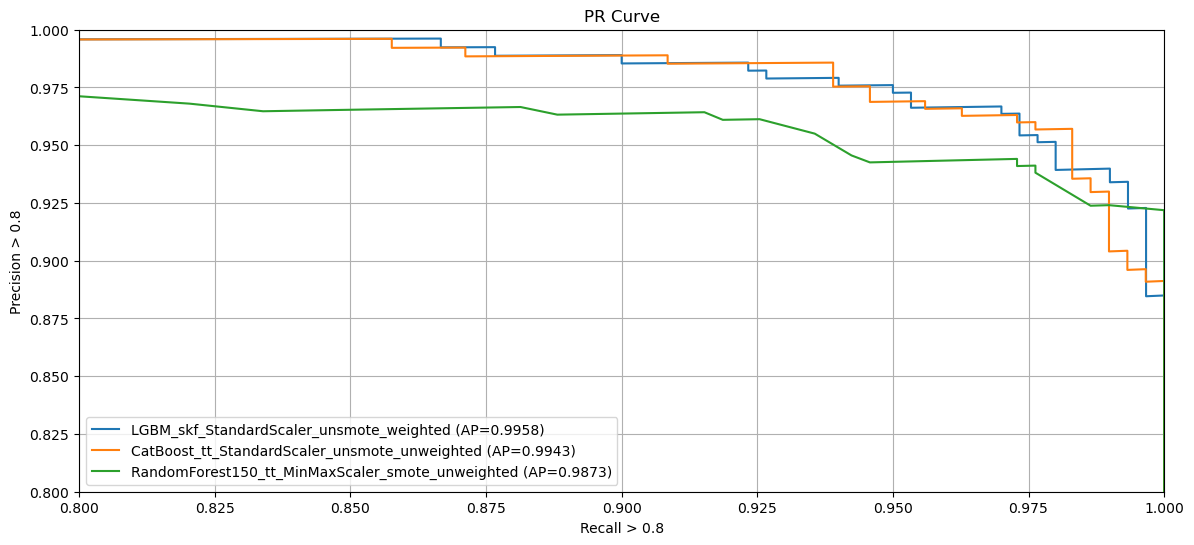

In [639]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(cb_lr1)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.8, x_max=1, label=idx, ylab='Precision > 0.8', xlab='Recall > 0.8', title='PR Curve')
    
plt.show()

In [313]:
[x for x in results_df.index if 'CatBoost_sss_MinMax' in x]

['CatBoost_sss_MinMaxScaler_unsmote_unweighted',
 'CatBoost_sss_MinMaxScaler_unsmote_weighted',
 'CatBoost_sss_MinMaxScaler_smote_unweighted',
 'CatBoost_sss_MinMaxScaler_smote_weighted']

In [333]:
#results_df.drop_duplicates(subset=['precision','recall','f1','accuracy']).sort_values(by='roc_auc',ascending=False).head(20)

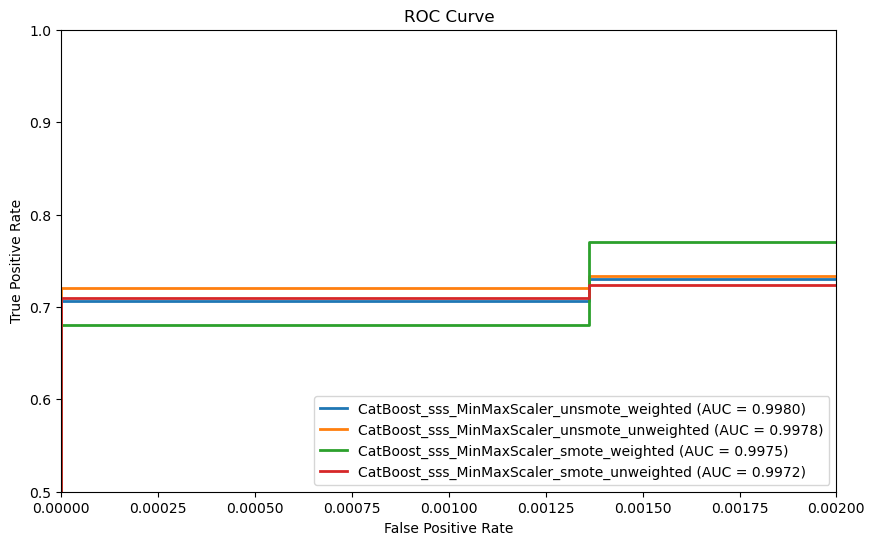

In [318]:
plt.figure(figsize=(10, 6))

for idx, row in results_df[results_df.index.isin([x for x in results_df.index if 'CatBoost_sss_MinMax' in x])].sort_values(by='roc_auc', ascending=False).iterrows():
    if type(row['roc_curve_class_1']) == str:
        fpr, tpr, row_t = string_array_split(row['roc_curve_class_1'])
    else:
        fpr, tpr, row_t = row['roc_curve_class_1']
    roc_auc = row['roc_auc_class_1']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_min=0, x_max=0.002, y_min=0.5, label=label)

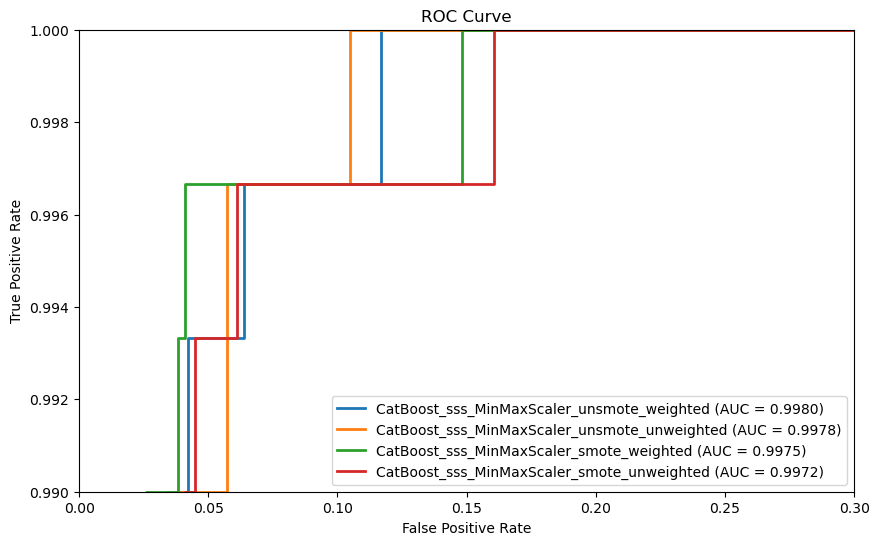

In [339]:
plt.figure(figsize=(10, 6))

for idx, row in results_df[results_df.index.isin([x for x in results_df.index if 'CatBoost_sss_MinMax' in x])].sort_values(by='roc_auc', ascending=False).iterrows():
    if type(row['roc_curve_class_1']) == str:
        fpr, tpr, row_t = string_array_split(row['roc_curve_class_1'])
    else:
        fpr, tpr, row_t = row['roc_curve_class_1']
    roc_auc = row['roc_auc_class_1']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_min=0.0, x_max=0.3, y_min=0.99, label=label)

In [323]:
#results_df.sort_values(by='fp').head(25)

In [129]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# Initialize results list
results = []

# Iterate through each row in the DataFrame
for idx, row in results_df.iterrows():
    # Check if the entry is a string representation of the precision-recall tuple
    if isinstance(row['precision_recall_class_1'], str):
        pr, re, th = eval(row['precision_recall_class_1'], {'array': np.array})
    else:
        pr, re, th = row['precision_recall_class_1']

    # Find indices where precision is 1.0
    precision_1_indices = np.where(pr == 1.0)[0]
    
    # Calculate recall at precision == 1.0
    if precision_1_indices.size > 0:
        recall_at_precision_1 = re[precision_1_indices].max()
    else:
        recall_at_precision_1 = None  # No recall when precision == 1.0

    # Find indices where recall is 1.0
    recall_1_indices = np.where(re == 1.0)[0]

    # Calculate precision at recall == 1.0
    if recall_1_indices.size > 0:
        precision_at_recall_1 = pr[recall_1_indices].max()
    else:
        precision_at_recall_1 = None  # No precision when recall == 1.0

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (pr * re) / (pr + re + 1e-10)  # Add a small epsilon to avoid division by zero

    # Find the maximum F1 score and the corresponding threshold
    max_f1_index = np.argmax(f1_scores)
    max_f1_score = f1_scores[max_f1_index]
    optimal_threshold = th[max_f1_index]

    # Append the result as a tuple with index, recall, precision, F1 score, and optimal threshold
    results.append((idx, recall_at_precision_1, precision_at_recall_1, max_f1_score, optimal_threshold))

# Convert results to a DataFrame if desired
tops_df = pd.DataFrame(results, columns=['model', 'recall_at_precision_1', 'precision_at_recall_1', 'max_f1_score', 'optimal_threshold']).set_index('model')

# 100% Recall

In [147]:
models_recall = ['RandomForest150_tt_MinMaxScaler_smote_unweighted', 'RandomForest150_tt_MinMaxScaler_smote_weighted',
                 'RandomForest150_tt_MinMaxScaler_unsmote_unweighted', 'RandomForest150_tt_MaxAbsScaler_unsmote_weighted']


mods_recall = ['CatBoost_tt_StandardScaler_unsmote_unweighted', 'RandomForest150_tt_MinMaxScaler_smote_unweighted',
              'LGBM_skf_MinMaxScaler_unsmote_weighted', 'CatBoost_tt_StandardScaler_smote_weighted']

In [485]:
tops_df.loc[['RandomForest150_sss_MinMaxScaler_smote_unweighted', 'LGBM_skf_MaxAbsScaler_unsmote_unweighted']]

,recall_at_precision_1,precision_at_recall_1,max_f1_score,optimal_threshold
model,,,,
RandomForest150_sss_MinMaxScaler_smote_unweighted,0.136667,0.697674,0.969106,0.520000
LGBM_skf_MaxAbsScaler_unsmote_unweighted,0.763333,0.884956,0.968491,0.495812


In [487]:
tops_df.sort_values(by='precision_at_recall_1', ascending=False)[['precision_at_recall_1','recall_at_precision_1', 'max_f1_score', 'optimal_threshold']].head(15)

,precision_at_recall_1,recall_at_precision_1,max_f1_score,optimal_threshold
model,,,,
RandomForest150_tt_MinMaxScaler_smote_unweighted,0.921875,0.477966,0.959350,0.493333
RandomForest150_tt_MinMaxScaler_smote_weighted,0.913313,0.633898,0.958264,0.546667
RandomForest150_tt_MinMaxScaler_unsmote_unweighted,0.907692,0.359322,0.969900,0.486667
RandomForest150_tt_MaxAbsScaler_unsmote_weighted,0.902141,0.416949,0.965058,0.480000
RandomForest150_tt_MaxAbsScaler_smote_unweighted,0.899390,0.427119,0.961857,0.513333
CatBoost_tt_StandardScaler_unsmote_unweighted,0.891239,0.508475,0.969900,0.434900
RandomForest150_tt_StandardScaler_unsmote_unweighted,0.891239,0.457627,0.959596,0.493333
CatBoost_tt_MinMaxScaler_unsmote_unweighted,0.891239,0.508475,0.969900,0.434900
CatBoost_tt_MaxAbsScaler_unsmote_unweighted,0.891239,0.508475,0.969900,0.434900


In [522]:
p_99s = ['LogisticRegression_sss_MinMaxScaler_unsmote_weighted', 'CatBoost_skf_MinMaxScaler_smote_weighted',
'LogisticRegression_sss_MinMaxScaler_smote_weighted', 'CatBoost_skf_MinMaxScaler_unsmote_weighted']

In [550]:
f1_dfs = pd.DataFrame(list(top_f1s.items()), columns=['index', 'max_f1']).set_index('index')
f1_dfs.drop_duplicates(subset='max_f1').sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
LGBM_skf_StandardScaler_smote_weighted,0.978512
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.976589
LGBM_skf_MinMaxScaler_smote_weighted,0.975042
CatBoost_skf_MinMaxScaler_smote_weighted,0.974790
LGBM_sss_MinMaxScaler_unsmote_weighted,0.973510
CatBoost_tt_MinMaxScaler_unsmote_weighted,0.973064
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.971993
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.971901
CatBoost_sss_MinMaxScaler_smote_unweighted,0.971714


In [644]:
tops_df[tops_df.index.isin(f1_dfs.drop_duplicates(subset='max_f1').sort_values(by='max_f1',ascending=False).head(15).index)].sort_values(by='max_f1_score',ascending=False)

,recall_at_precision_1,precision_at_recall_1,max_f1_score,optimal_threshold
model,,,,
LGBM_skf_StandardScaler_smote_weighted,0.603333,0.842697,0.978512,0.573696
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.706667,0.777202,0.976589,0.556067
LGBM_skf_MinMaxScaler_smote_weighted,0.570000,0.808625,0.975042,0.655214
CatBoost_skf_MinMaxScaler_smote_weighted,0.706667,0.789474,0.974790,0.718492
LGBM_sss_MinMaxScaler_unsmote_weighted,0.816667,0.699301,0.973510,0.530220
CatBoost_tt_MinMaxScaler_unsmote_weighted,0.488136,0.870206,0.973064,0.540427
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.836667,0.773196,0.971993,0.429214
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.826667,0.750000,0.971901,0.400109
CatBoost_sss_MinMaxScaler_smote_unweighted,0.710000,0.717703,0.971714,0.687580


In [599]:
p_prec.sort_values(by='max_f1',ascending=False).head(10)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_weighted,0.928571
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.928571
CatBoost_skf_MaxAbsScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.911071
CatBoost_skf_StandardScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.905109
CatBoost_skf_StandardScaler_unsmote_unweighted,0.905109


In [587]:
tops_df.sort_values(by='max_f1_score', ascending=False).head(25)

,recall_at_precision_1,precision_at_recall_1,max_f1_score,optimal_threshold
model,,,,
LGBM_skf_StandardScaler_smote_weighted,0.603333,0.842697,0.978512,0.573696
LGBM_skf_StandardScaler_smote_unweighted,0.603333,0.842697,0.978512,0.573696
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.706667,0.777202,0.976589,0.556067
CatBoost_sss_MaxAbsScaler_unsmote_weighted,0.706667,0.777202,0.976589,0.556067
CatBoost_sss_StandardScaler_unsmote_weighted,0.706667,0.777202,0.976589,0.556067
LGBM_skf_MaxAbsScaler_smote_unweighted,0.570000,0.808625,0.975042,0.655214
LGBM_skf_MaxAbsScaler_smote_weighted,0.570000,0.808625,0.975042,0.655214
LGBM_skf_MinMaxScaler_smote_unweighted,0.570000,0.808625,0.975042,0.655214
LGBM_skf_MinMaxScaler_smote_weighted,0.570000,0.808625,0.975042,0.655214


In [559]:
results_df.drop_duplicates(subset='roc_auc').sort_values(by='roc_auc', ascending=False).head(5)

,accuracy,precision,recall,f1,roc_auc,tp,tn,fp,fn,precision_recall_class_1,average_precision_class_1,roc_curve_class_1,roc_auc_class_1,precision_recall_class_0,average_precision_class_0,model,split_method,scaler,smote,weighted
index,,,,,,,,,,,,,,,,,,,,
CatBoost_skf_MinMaxScaler_smote_weighted,0.973888,0.927900,0.986667,0.956381,0.998342,296,711,23,4,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.996057,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.998342,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999333,CatBoost,skf,MinMaxScaler,smote,weighted
LGBM_skf_MinMaxScaler_unsmote_weighted,0.980658,0.963576,0.970000,0.966777,0.998292,291,723,11,9,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.995784,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.998292,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999323,LGBM,skf,MinMaxScaler,unsmote,weighted
CatBoost_skf_MinMaxScaler_smote_unweighted,0.974855,0.933544,0.983333,0.957792,0.998224,295,713,21,5,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.995654,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.998224,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999294,CatBoost,skf,MinMaxScaler,smote,unweighted
LGBM_skf_StandardScaler_smote_weighted,0.984526,0.961039,0.986667,0.973684,0.998202,296,722,12,4,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.995299,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013623...",0.998202,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999306,LGBM,skf,StandardScaler,smote,weighted
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.980658,0.966667,0.966667,0.966667,0.998097,290,724,10,10,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.995652,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.998097,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999222,CatBoost,skf,MinMaxScaler,unsmote,weighted


In [641]:
#results_df.sort_values(by='f1', ascending=False).head(15)

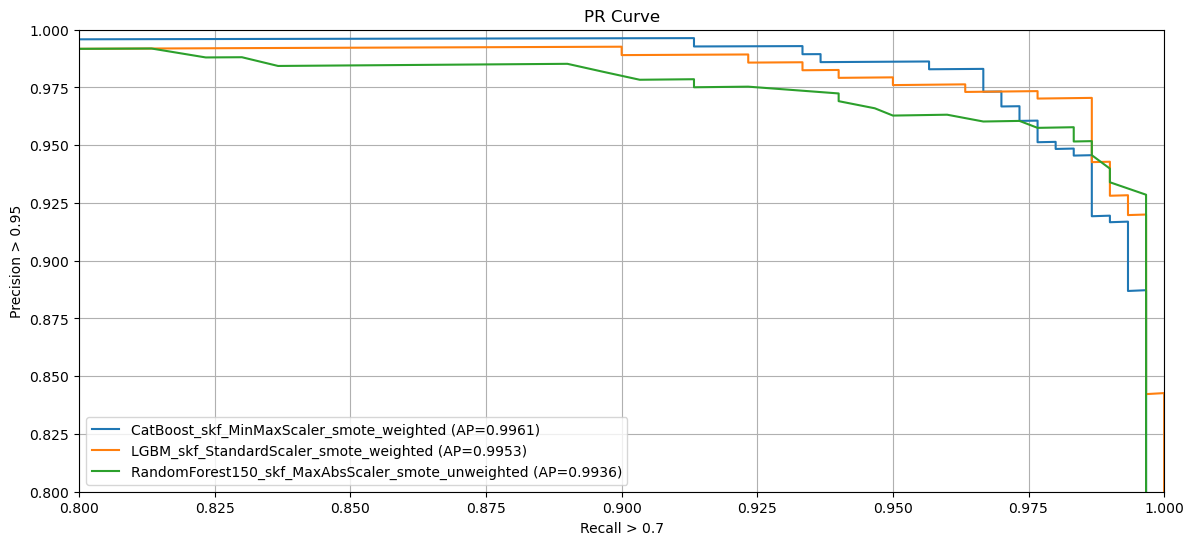

In [556]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(f1_ms)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.8, x_max=1, label=idx, ylab='Precision > 0.95', xlab='Recall > 0.7', title='PR Curve')
    
plt.show()

In [555]:
f1_ms = ['LGBM_skf_StandardScaler_smote_weighted', 
         'RandomForest150_skf_MaxAbsScaler_smote_unweighted', 'CatBoost_skf_MinMaxScaler_smote_weighted']

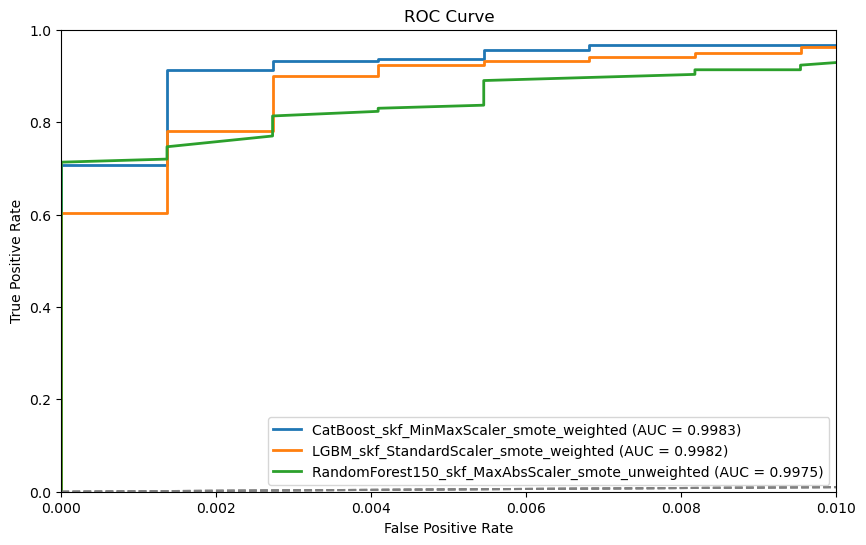

In [581]:
plt.figure(figsize=(10, 6))

for idx, row in results_df[results_df.index.isin(f1_ms)].sort_values(by='roc_auc', ascending=False).iterrows():
    if type(row['roc_curve_class_1']) == str:
        fpr, tpr, row_t = string_array_split(row['roc_curve_class_1'])
    else:
        fpr, tpr, row_t = row['roc_curve_class_1']
    roc_auc = row['roc_auc_class_1']
    label=idx
    plot_roc_curve(fpr, tpr, roc_auc,x_max=0.01, y_min=0, label=label)

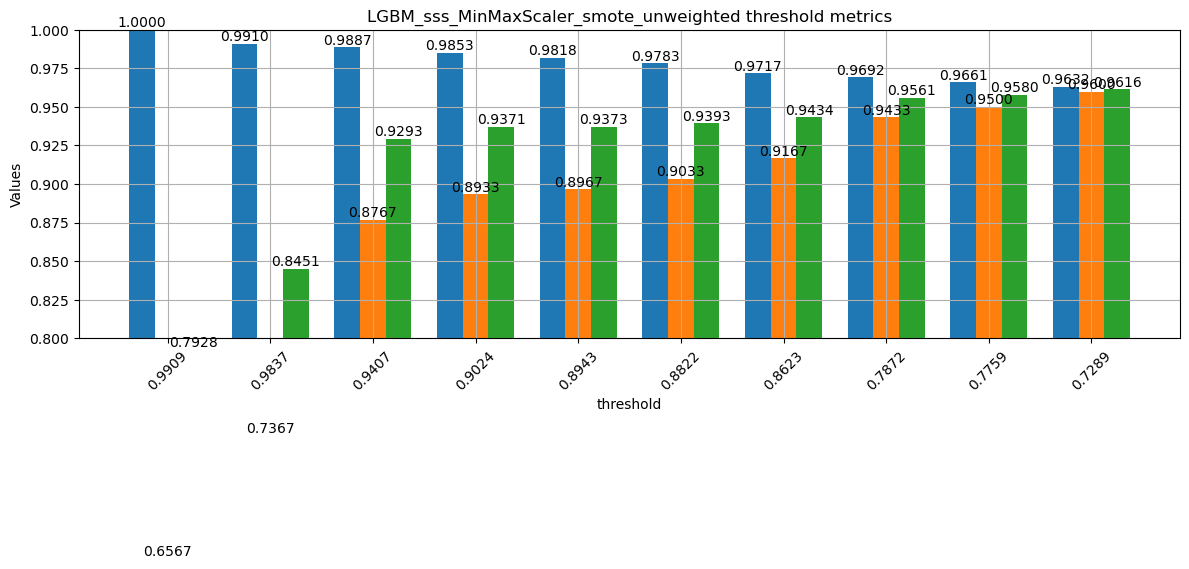

In [606]:
plot_bar_graphs(diff_dc['LGBM_sss_MinMaxScaler_unsmote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(10), 
['precision','recall','f1'], title ='LGBM_sss_MinMaxScaler_unsmote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.8, figsize=(12,8), legend=False)

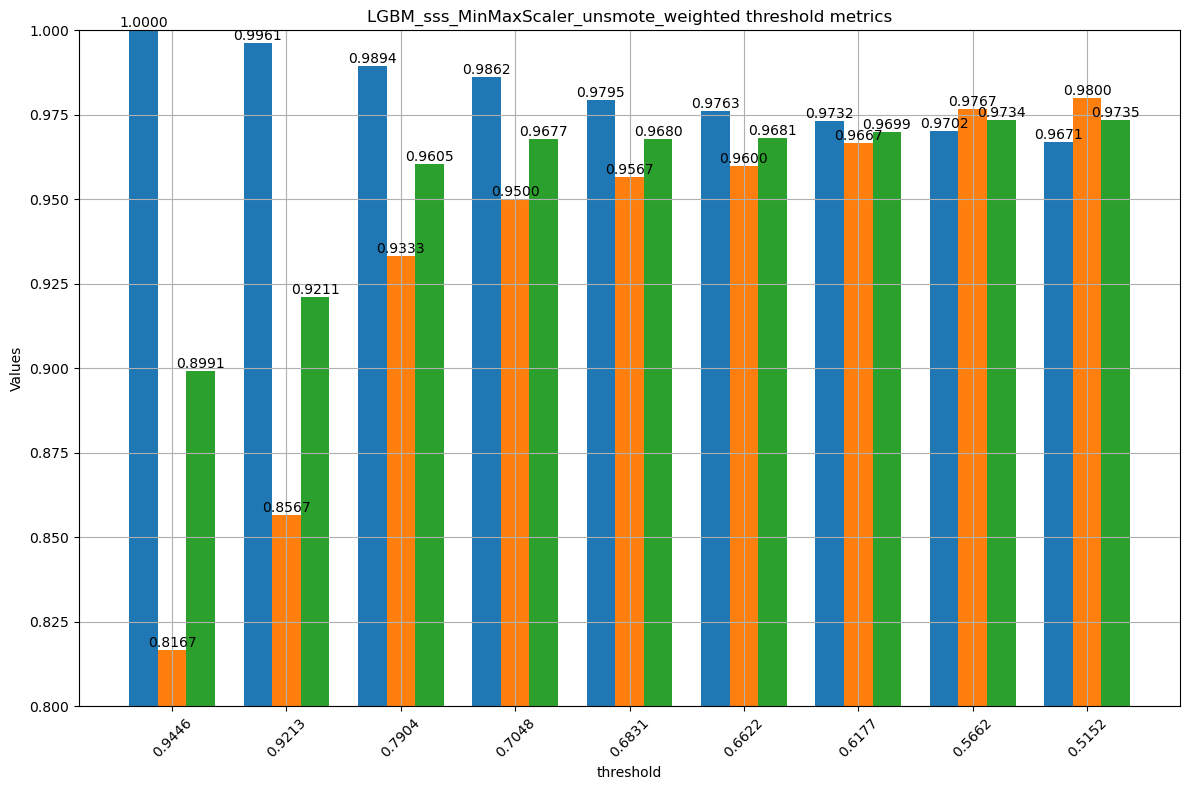

In [648]:
plot_bar_graphs(diff_dc['LGBM_sss_MinMaxScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(9), 
['precision','recall','f1'], title ='LGBM_sss_MinMaxScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.8, figsize=(12,8), legend=False)

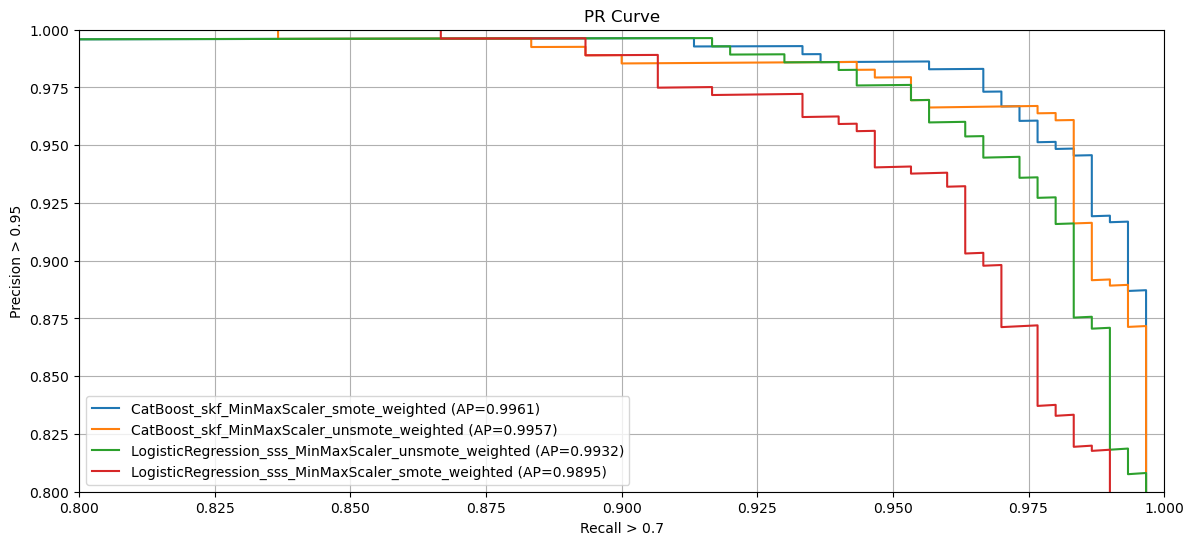

In [543]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(f1_ms)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.8, x_max=1, label=idx, ylab='Precision > 0.95', xlab='Recall > 0.7', title='PR Curve')
    
plt.show()

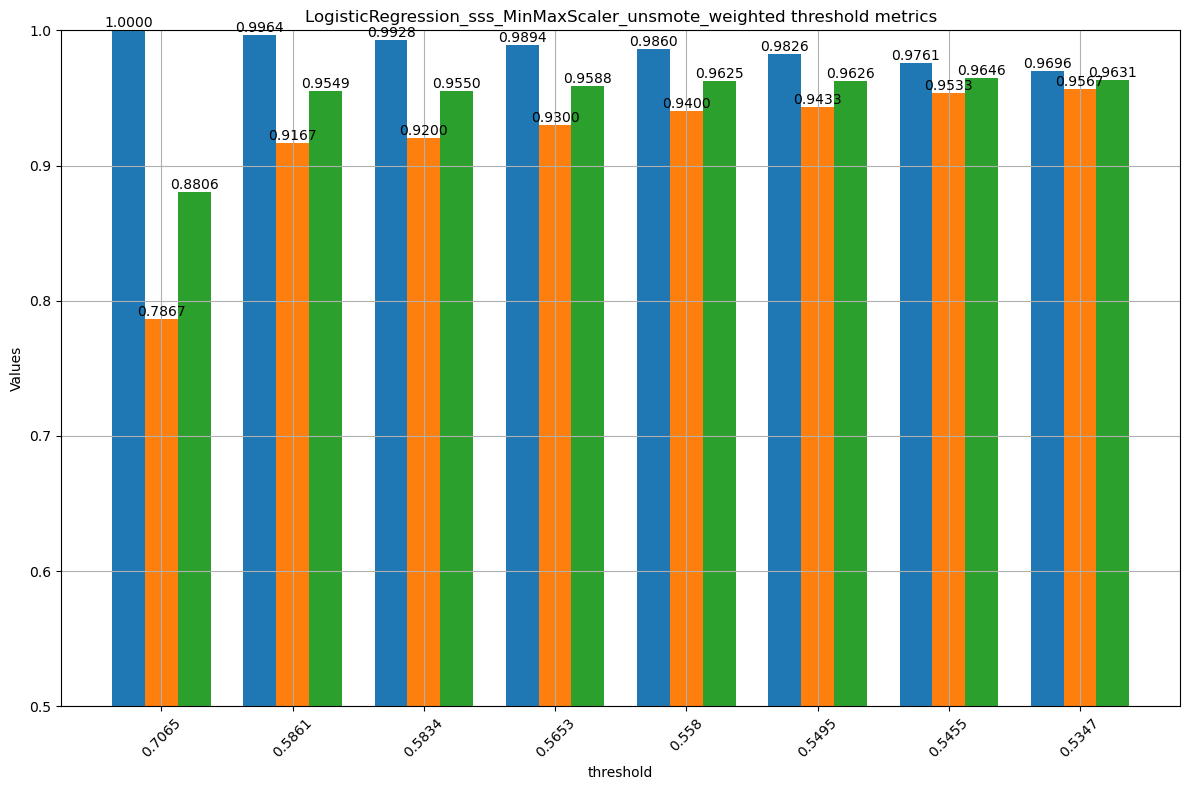

In [549]:
plot_bar_graphs(diff_dc['LogisticRegression_sss_MinMaxScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='LogisticRegression_sss_MinMaxScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(12,8), legend=False)

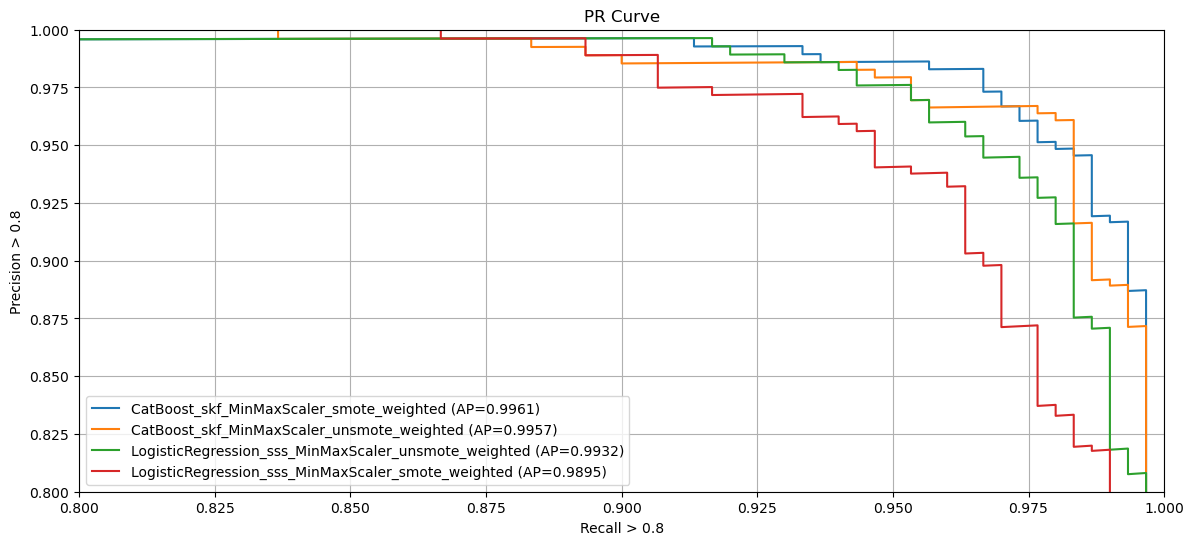

In [541]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(p_99s)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.8, x_max=1, label=idx, ylab='Precision > 0.8', xlab='Recall > 0.8', title='PR Curve')
    
plt.show()

In [500]:
tops_df.sort_values(by='precision_at_recall_1', ascending=False).head(15)

,recall_at_precision_1,precision_at_recall_1,max_f1_score,optimal_threshold
model,,,,
RandomForest150_tt_MinMaxScaler_smote_unweighted,0.477966,0.921875,0.959350,0.493333
RandomForest150_tt_MinMaxScaler_smote_weighted,0.633898,0.913313,0.958264,0.546667
RandomForest150_tt_MinMaxScaler_unsmote_unweighted,0.359322,0.907692,0.969900,0.486667
RandomForest150_tt_MaxAbsScaler_unsmote_weighted,0.416949,0.902141,0.965058,0.480000
RandomForest150_tt_MaxAbsScaler_smote_unweighted,0.427119,0.899390,0.961857,0.513333
CatBoost_tt_StandardScaler_unsmote_unweighted,0.508475,0.891239,0.969900,0.434900
RandomForest150_tt_StandardScaler_unsmote_unweighted,0.457627,0.891239,0.959596,0.493333
CatBoost_tt_MinMaxScaler_unsmote_unweighted,0.508475,0.891239,0.969900,0.434900
CatBoost_tt_MaxAbsScaler_unsmote_unweighted,0.508475,0.891239,0.969900,0.434900


In [505]:
r_99.sort_values(by='max_f1', ascending=False).head(15)

,max_f1
index,
RandomForest150_sss_MinMaxScaler_smote_unweighted,0.967638
RandomForest150_sss_MaxAbsScaler_smote_weighted,0.961415
LGBM_skf_MaxAbsScaler_unsmote_unweighted,0.958333
LGBM_skf_MaxAbsScaler_unsmote_weighted,0.958333
LGBM_skf_StandardScaler_unsmote_unweighted,0.958333
LGBM_skf_StandardScaler_unsmote_weighted,0.958333
LGBM_skf_MinMaxScaler_unsmote_unweighted,0.958333
LGBM_skf_MinMaxScaler_unsmote_weighted,0.958333
LGBM_skf_StandardScaler_smote_unweighted,0.956800


In [501]:
r99s = ['RandomForest150_tt_MinMaxScaler_smote_unweighted', 'LGBM_skf_MaxAbsScaler_unsmote_unweighted',
        'RandomForest150_skf_StandardScaler_smote_weighted', 'CatBoost_tt_MaxAbsScaler_unsmote_weighted']

In [472]:
rfs = ['RandomForest150_tt_MinMaxScaler_smote_unweighted', 'RandomForest150_tt_MinMaxScaler_smote_weighted',
      'RandomForest150_tt_MinMaxScaler_unsmote_weighted', 'RandomForest150_tt_MinMaxScaler_unsmote_unweighted',
      'CatBoost_tt_MinMaxScaler_unsmote_unweighted']

In [464]:
res = ['CatBoost_tt_MinMaxScaler_unsmote_unweighted', 'RandomForest150_tt_MinMaxScaler_smote_weighted', 
       'LGBM_skf_MinMaxScaler_unsmote_weighted', 'RandomForest150_tt_MaxAbsScaler_smote_unweighted', 'RandomForest150_tt_MinMaxScaler_unsmote_unweighted'
      ]

In [476]:
rfs

['RandomForest150_tt_MinMaxScaler_smote_unweighted',
 'RandomForest150_tt_MinMaxScaler_smote_weighted',
 'RandomForest150_tt_MinMaxScaler_unsmote_weighted',
 'RandomForest150_tt_MinMaxScaler_unsmote_unweighted',
 'CatBoost_tt_MinMaxScaler_unsmote_unweighted']

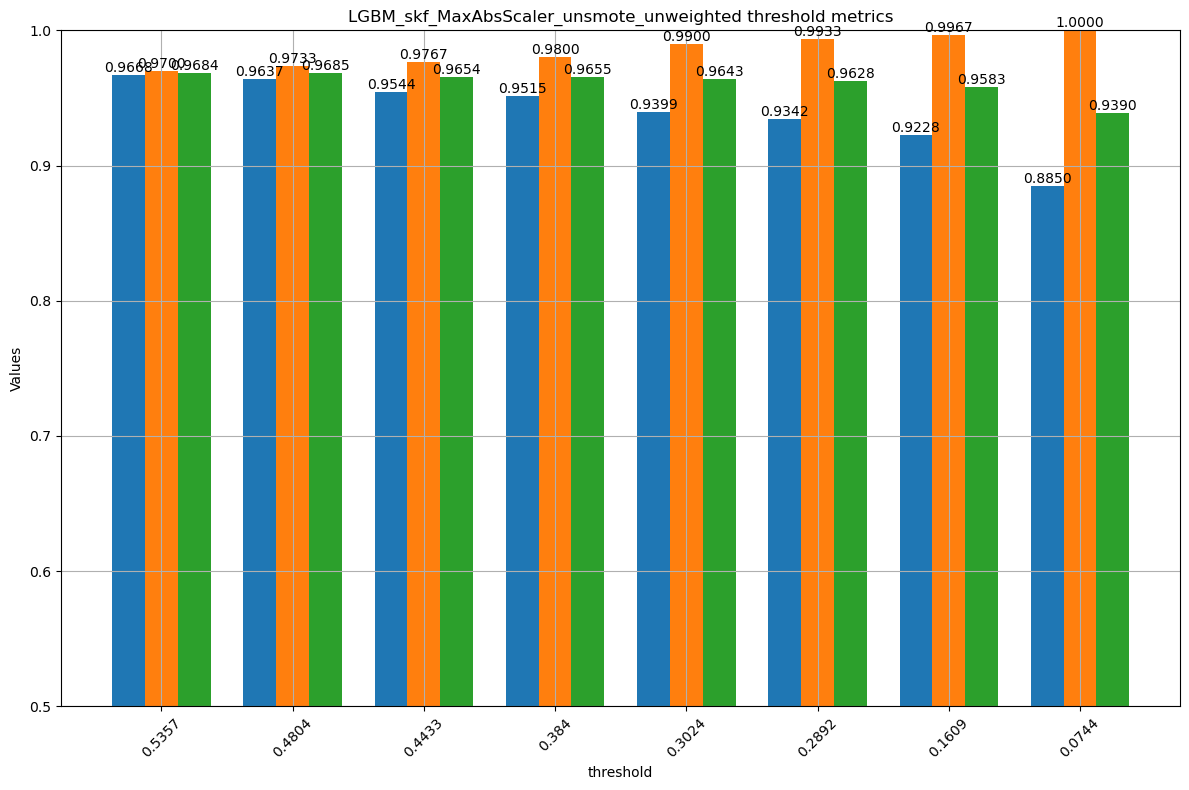

In [515]:
plot_bar_graphs(diff_dc['LogisticRegression_sss_MinMaxScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='LogisticRegression_sss_MinMaxScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(12,8), legend=False)

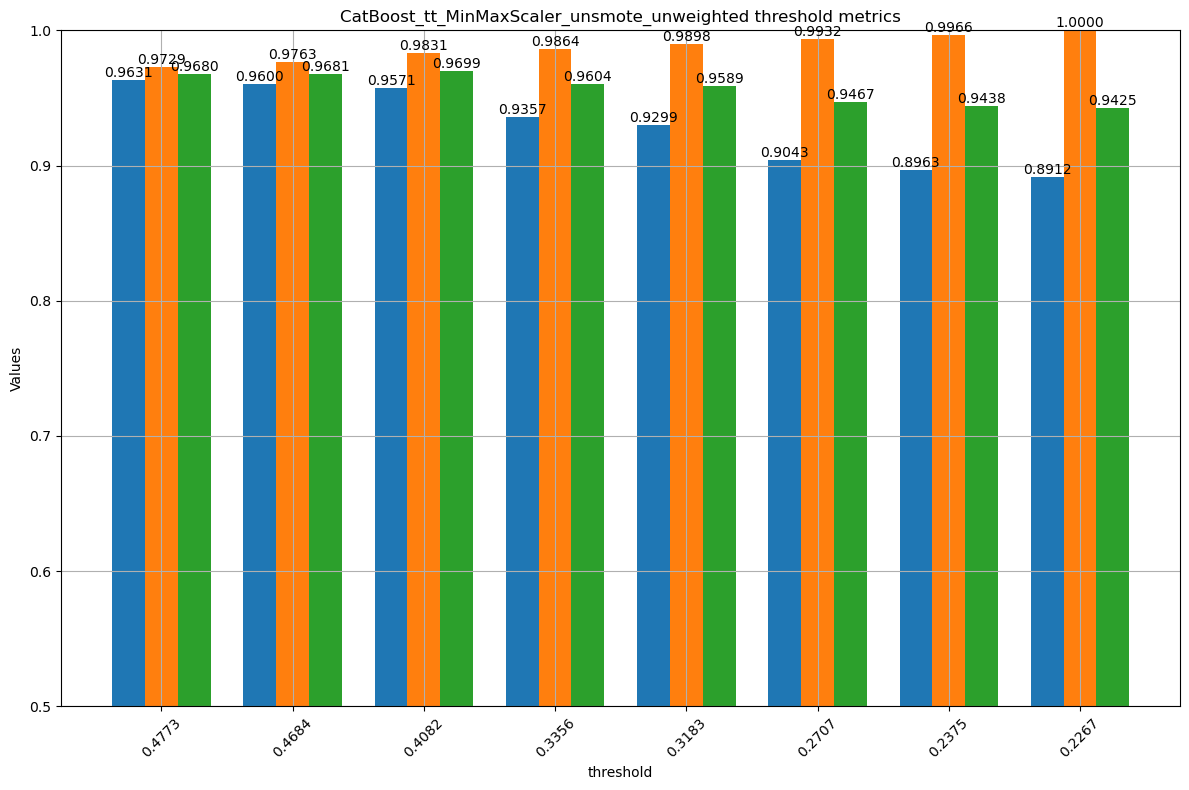

In [480]:
plot_bar_graphs(diff_dc['CatBoost_tt_MinMaxScaler_unsmote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='CatBoost_tt_MinMaxScaler_unsmote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(12,8), legend=False)

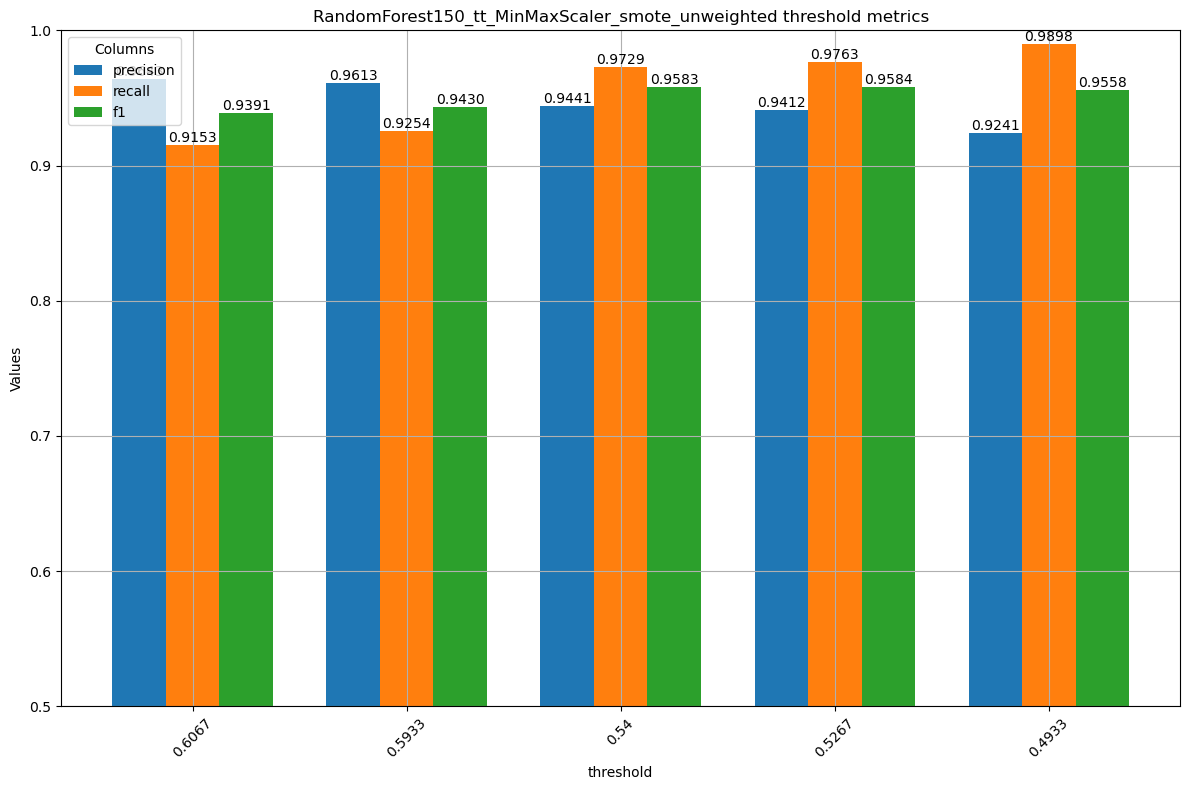

In [145]:
plot_bar_graphs(diff_dc['CatBoost_skf_MinMaxScaler_smote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(5), 
['precision','recall','f1'], title ='CatBoost_skf_MinMaxScaler_smote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(12,8))

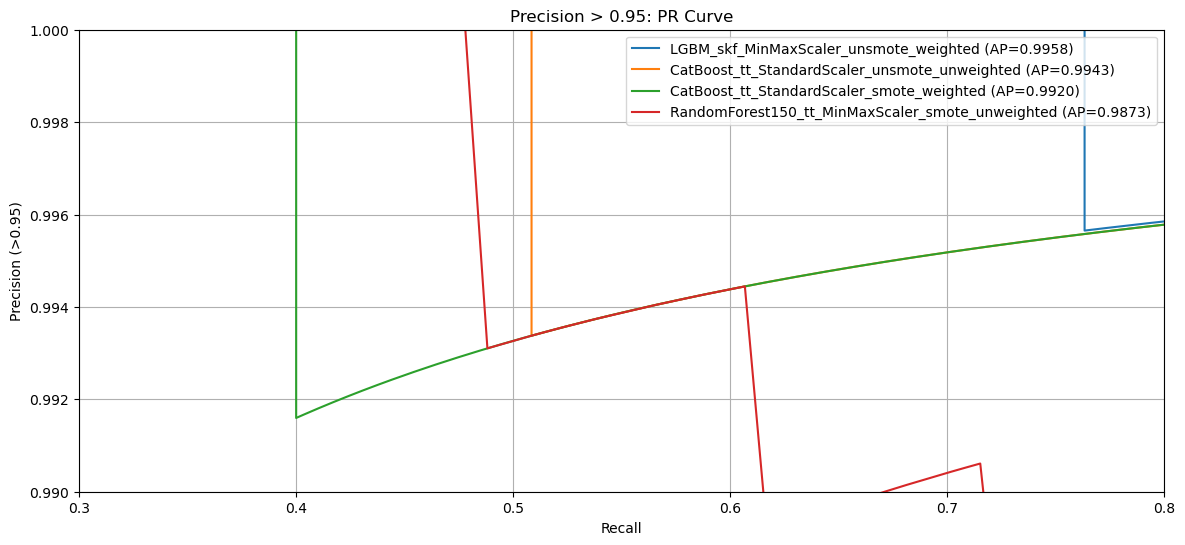

In [432]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(mods_recall)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.3, x_max=0.8, y_min=0.99, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

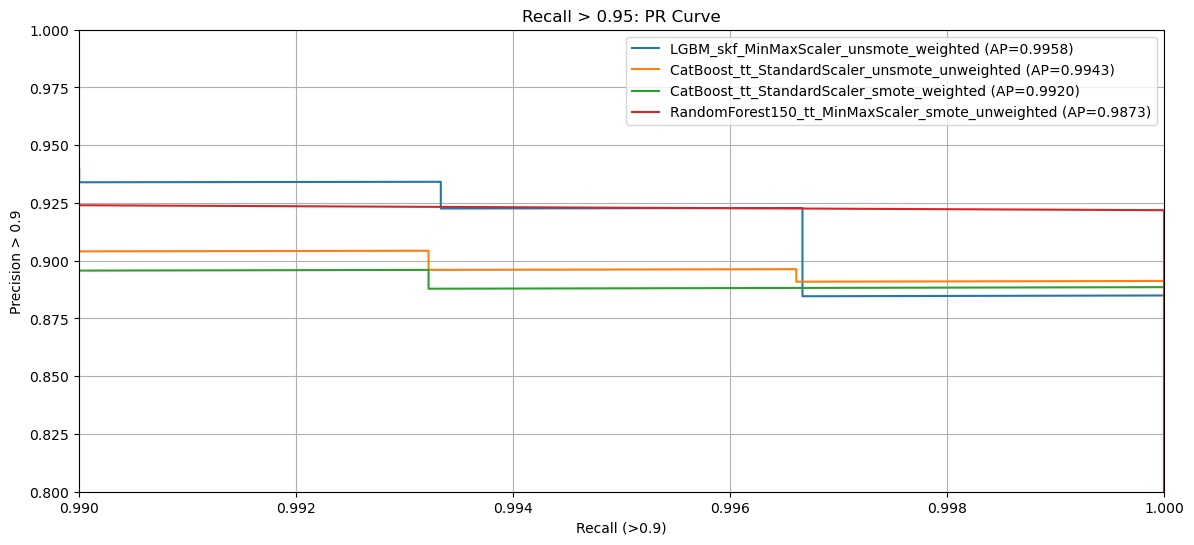

In [434]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(mods_recall)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.99, x_max=1, label=idx, ylab='Precision > 0.9', xlab='Recall (>0.9)', title='Recall > 0.95: PR Curve')
    
plt.show()

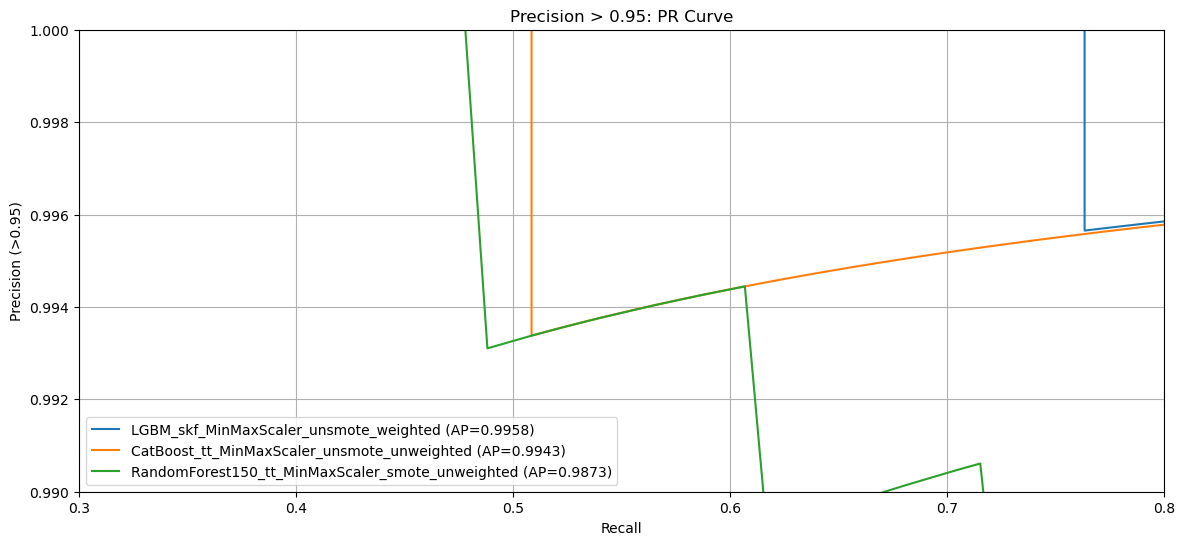

In [436]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(res)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.3, x_max=0.8, y_min=0.99, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

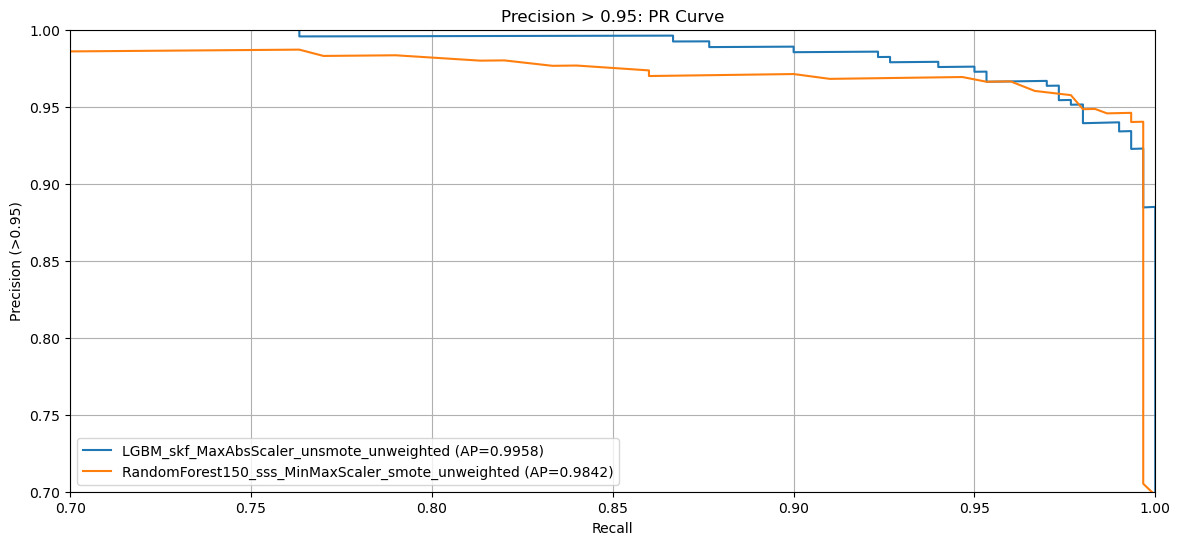

In [483]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(['RandomForest150_sss_MinMaxScaler_smote_unweighted', 'LGBM_skf_MaxAbsScaler_unsmote_unweighted'])].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.7, y_min=0.7, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

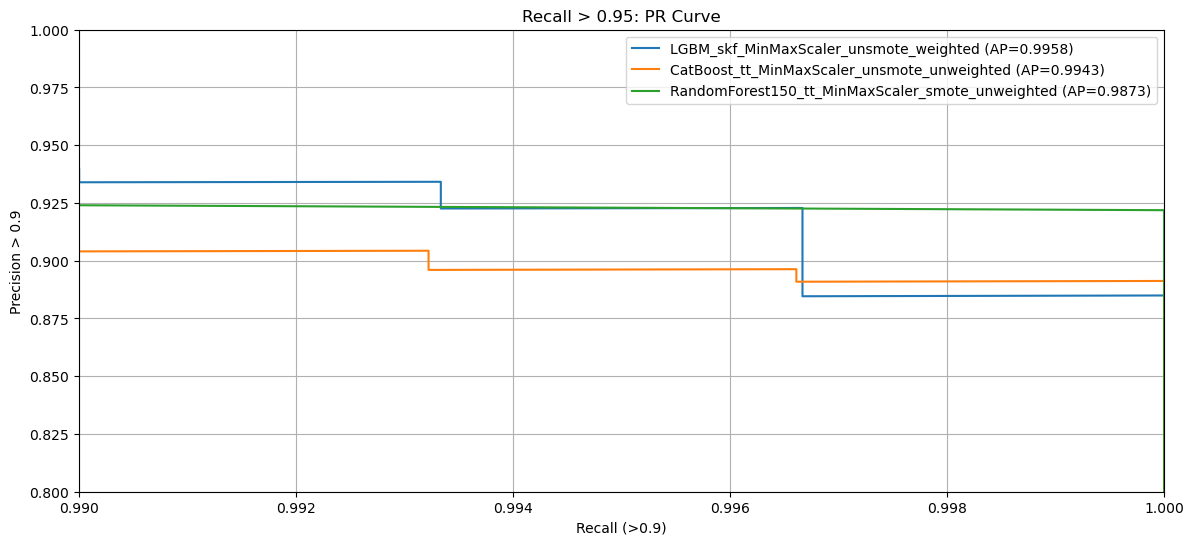

In [435]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(res)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.8, x_min=0.99, x_max=1, label=idx, ylab='Precision > 0.9', xlab='Recall (>0.9)', title='Recall > 0.95: PR Curve')
    
plt.show()

In [441]:
results_df.sort_values(by='fp').head(10)

,accuracy,precision,recall,f1,roc_auc,tp,tn,fp,fn,precision_recall_class_1,average_precision_class_1,roc_curve_class_1,roc_auc_class_1,precision_recall_class_0,average_precision_class_0,model,split_method,scaler,smote,weighted
index,,,,,,,,,,,,,,,,,,,,
CatBoost_sss_MinMaxScaler_unsmote_unweighted,0.978744,0.976027,0.950000,0.962838,0.997751,285,728,7,15,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.994558,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...",0.997751,"([0.7101449275362319, 0.7108317214700194, 0.71...",0.999104,CatBoost,sss,MinMaxScaler,unsmote,unweighted
CatBoost_sss_StandardScaler_unsmote_unweighted,0.978744,0.976027,0.950000,0.962838,0.997751,285,728,7,15,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.994558,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...",0.997751,"([0.7101449275362319, 0.7108317214700194, 0.71...",0.999104,CatBoost,sss,StandardScaler,unsmote,unweighted
CatBoost_sss_MaxAbsScaler_unsmote_unweighted,0.978744,0.976027,0.950000,0.962838,0.997751,285,728,7,15,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.994558,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...",0.997751,"([0.7101449275362319, 0.7108317214700194, 0.71...",0.999104,CatBoost,sss,MaxAbsScaler,unsmote,unweighted
RandomForest150_sss_MinMaxScaler_unsmote_weighted,0.976812,0.972603,0.946667,0.959459,0.997156,284,727,8,16,"([0.2898550724637681, 0.3412969283276451, 0.36...",0.991801,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.997156,"([0.7101449275362319, 0.7122093023255814, 0.71...",0.998893,RandomForest150,sss,MinMaxScaler,unsmote,weighted
RandomForest150_sss_MinMaxScaler_unsmote_unweighted,0.977778,0.972696,0.950000,0.961214,0.996279,285,727,8,15,"([0.2898550724637681, 0.3401360544217687, 0.36...",0.989696,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.996279,"([0.7101449275362319, 0.7115198451113263, 0.71...",0.998541,RandomForest150,sss,MinMaxScaler,unsmote,unweighted
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.977756,0.969492,0.953333,0.961345,0.997748,286,725,9,14,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.994865,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.997748,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999080,CatBoost,skf,MinMaxScaler,unsmote,unweighted
CatBoost_skf_StandardScaler_unsmote_unweighted,0.977756,0.969492,0.953333,0.961345,0.997748,286,725,9,14,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.994865,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.997748,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999080,CatBoost,skf,StandardScaler,unsmote,unweighted
CatBoost_skf_MaxAbsScaler_unsmote_unweighted,0.977756,0.969492,0.953333,0.961345,0.997748,286,725,9,14,"([0.2901353965183752, 0.2904162633107454, 0.29...",0.994865,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136239782016348...",0.997748,"([0.7098646034816247, 0.7105517909002904, 0.71...",0.999080,CatBoost,skf,MaxAbsScaler,unsmote,unweighted
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.984541,0.970199,0.976667,0.973422,0.997982,293,726,9,7,"([0.2898550724637681, 0.2901353965183752, 0.29...",0.995102,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013605...",0.997982,"([0.7101449275362319, 0.7108317214700194, 0.71...",0.999198,CatBoost,sss,MinMaxScaler,unsmote,weighted


In [340]:
#results_df.drop_duplicates(subset=['precision','recall','f1','accuracy']).sort_values(by='average_precision_class_1',ascending=False).head(20)

In [612]:
tops_df.drop_duplicates(subset=['recall_at_precision_1','max_f1_score']).sort_values(by='recall_at_precision_1', ascending=False)[['recall_at_precision_1','optimal_threshold', 'max_f1_score']].head(15)

,recall_at_precision_1,optimal_threshold,max_f1_score
model,,,
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.866667,0.740441,0.952381
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.836667,0.429214,0.971993
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.826667,0.400109,0.971901
LGBM_sss_MinMaxScaler_unsmote_weighted,0.816667,0.530220,0.973510
LogisticRegression_sss_MinMaxScaler_unsmote_weighted,0.786667,0.547190,0.964587
LGBM_sss_StandardScaler_unsmote_weighted,0.780000,0.443676,0.970199
LGBM_skf_MinMaxScaler_unsmote_weighted,0.763333,0.495812,0.968491
RandomForest150_skf_StandardScaler_smote_unweighted,0.760000,0.486667,0.961165
RandomForest150_skf_StandardScaler_unsmote_unweighted,0.733333,0.466667,0.960265


In [355]:
tops_df.sort_values(by='max_f1_score', ascending=False)[['recall_at_precision_1','optimal_threshold', 'max_f1_score']].head(15)

,recall_at_precision_1,optimal_threshold,max_f1_score
model,,,
LGBM_skf_StandardScaler_smote_weighted,0.603333,0.573696,0.978512
LGBM_skf_StandardScaler_smote_unweighted,0.603333,0.573696,0.978512
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.706667,0.556067,0.976589
CatBoost_sss_MaxAbsScaler_unsmote_weighted,0.706667,0.556067,0.976589
CatBoost_sss_StandardScaler_unsmote_weighted,0.706667,0.556067,0.976589
LGBM_skf_MaxAbsScaler_smote_unweighted,0.570000,0.655214,0.975042
LGBM_skf_MaxAbsScaler_smote_weighted,0.570000,0.655214,0.975042
LGBM_skf_MinMaxScaler_smote_unweighted,0.570000,0.655214,0.975042
LGBM_skf_MinMaxScaler_smote_weighted,0.570000,0.655214,0.975042


In [346]:
cbm = [x for x in results_df.index if ('CatBoost' in x) & ('_weighted' in x) & ('MinMaxScaler' in x) & ('tt' not in x)]

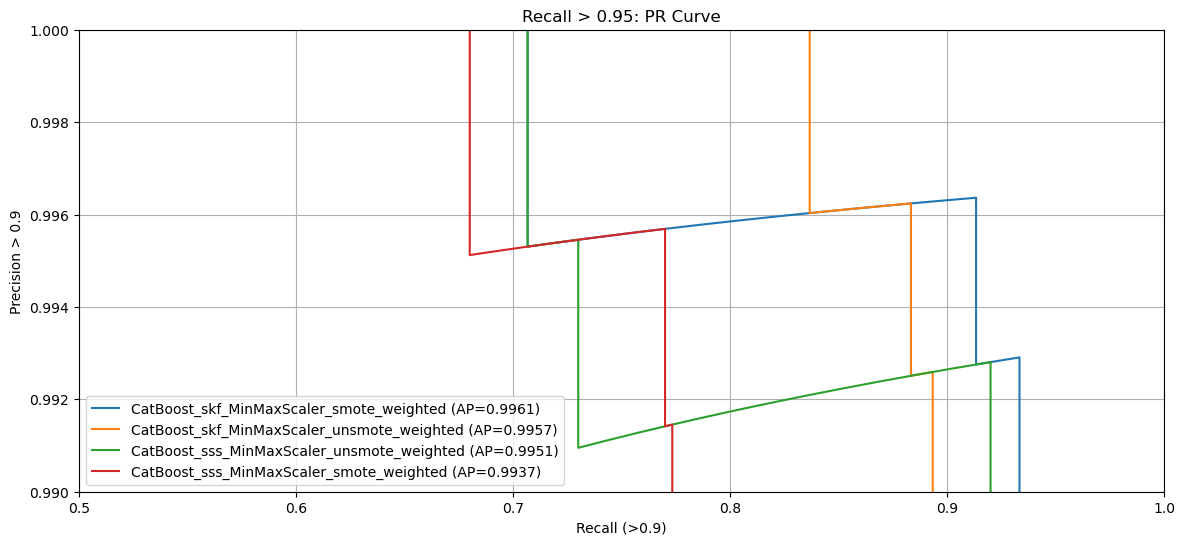

In [354]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(cbm)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,y_min=0.99, x_max=1, x_min=0.50, label=idx, ylab='Precision > 0.9', xlab='Recall (>0.9)', title='Recall > 0.95: PR Curve')
    
plt.show()

In [72]:
models_for_selection = ['LogisticRegression_sss_MinMaxScaler_smote_weighted', 'CatBoost_skf_MaxAbsScaler_unsmote_weighted',
                       'LGBM_sss_MinMaxScaler_unsmote_weighted', 'RandomForest150_tt_MinMaxScaler_smote_unweighted',
                        'LGBM_skf_StandardScaler_smote_weighted', 'CatBoost_sss_MinMaxScaler_unsmote_weighted',
                        'LGBM_skf_MinMaxScaler_unsmote_weighted', 'CatBoost_tt_StandardScaler_unsmote_unweighted' ]
models_for_selection

['LogisticRegression_sss_MinMaxScaler_smote_weighted',
 'CatBoost_skf_MaxAbsScaler_unsmote_weighted',
 'LGBM_sss_MinMaxScaler_unsmote_weighted',
 'RandomForest150_tt_MinMaxScaler_smote_unweighted',
 'LGBM_skf_StandardScaler_smote_weighted',
 'CatBoost_sss_MinMaxScaler_unsmote_weighted',
 'LGBM_skf_MinMaxScaler_unsmote_weighted',
 'CatBoost_tt_StandardScaler_unsmote_unweighted']

In [86]:
#tops_df.to_csv('tops_df1.csv')

In [389]:
diff_dc = df_to_diff_dc(results_df)

perfect_precision = {}
perfect_recall = {}
top_f1s = {}

top_99_rec = {}
top_99_pre = {}

for k,v in diff_dc.items():
    if not v[v['precision'] == 1].empty:
        perfect_precision[k] = v.loc[v['precision'] == 1, 'f1'].values[0]
 
    if not v[v['recall'] == 1].empty:
        perfect_recall[k] = v.loc[v['recall'] == 1, 'f1'].values[0]
   
    top_f1s[k] = v['f1'].max()

    if not v[v['recall'] > 0.99].empty:
        top_99_rec[k] = v[v['recall'] > 0.995]['f1'].max()
        
    if not v[v['precision'] > 0.99].empty:        
        top_99_pre[k] = v[v['precision'] > 0.995]['f1'].max() 

In [484]:
r_99 = pd.DataFrame(list(top_99_rec.items()), columns=['index', 'max_f1']).set_index('index')
r_99.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
RandomForest150_sss_MinMaxScaler_smote_unweighted,0.967638
RandomForest150_sss_MaxAbsScaler_smote_weighted,0.961415
LGBM_skf_MaxAbsScaler_unsmote_unweighted,0.958333
LGBM_skf_MaxAbsScaler_unsmote_weighted,0.958333
LGBM_skf_StandardScaler_unsmote_unweighted,0.958333
LGBM_skf_StandardScaler_unsmote_weighted,0.958333
LGBM_skf_MinMaxScaler_unsmote_unweighted,0.958333
LGBM_skf_MinMaxScaler_unsmote_weighted,0.958333
LGBM_skf_StandardScaler_smote_unweighted,0.956800


In [443]:
p_prec.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_weighted,0.928571
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.928571
CatBoost_skf_MaxAbsScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.911071
CatBoost_skf_StandardScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.905109
CatBoost_skf_StandardScaler_unsmote_unweighted,0.905109


In [449]:
p_99.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_unsmote_unweighted,0.954861
LogisticRegression_sss_MinMaxScaler_unsmote_weighted,0.954861
LogisticRegression_sss_MaxAbsScaler_unsmote_weighted,0.954861
LogisticRegression_sss_MaxAbsScaler_unsmote_unweighted,0.954861
CatBoost_skf_MaxAbsScaler_smote_weighted,0.953043
CatBoost_skf_StandardScaler_smote_weighted,0.953043
CatBoost_skf_MinMaxScaler_smote_weighted,0.953043
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.942004
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.942004


In [ ]:
res = ['RandomForest150_tt_MinMaxScaler_smote_unweighted', 'RandomForest150_sss_MinMaxScaler_smote_unweighted', ]

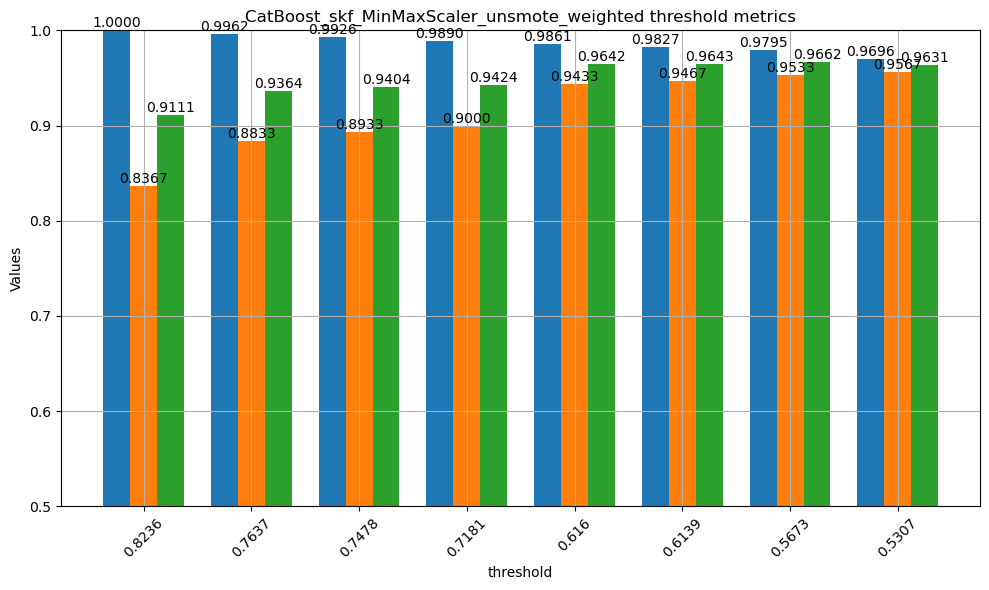

In [445]:
plot_bar_graphs(diff_dc['CatBoost_skf_MinMaxScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_skf_MinMaxScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

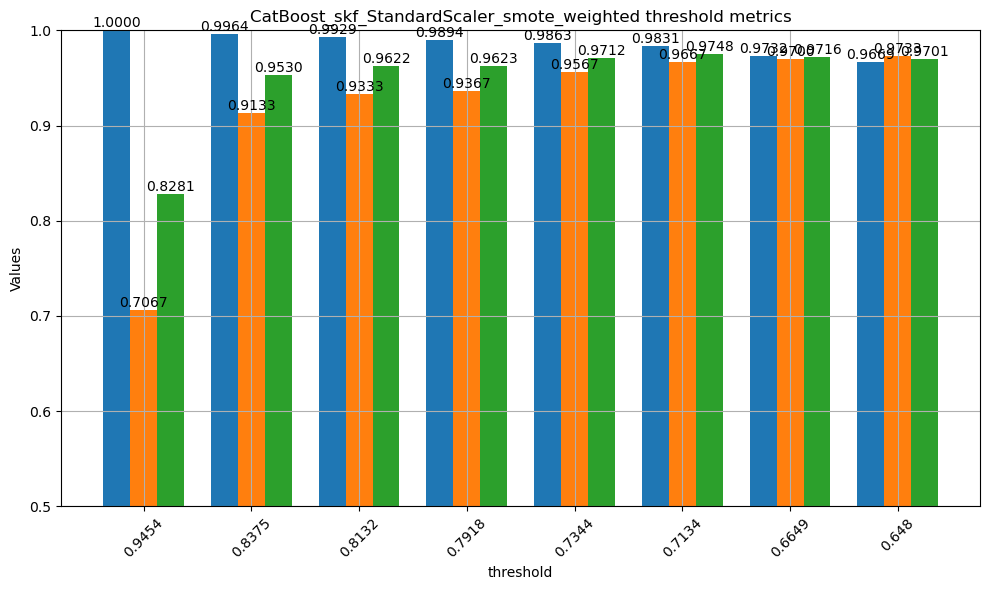

In [447]:
plot_bar_graphs(diff_dc['CatBoost_skf_StandardScaler_smote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_skf_StandardScaler_smote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

In [390]:
p_99 = pd.DataFrame(list(top_99_pre.items()), columns=['index', 'max_f1']).set_index('index')
p_99.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_unsmote_unweighted,0.954861
LogisticRegression_sss_MinMaxScaler_unsmote_weighted,0.954861
LogisticRegression_sss_MaxAbsScaler_unsmote_weighted,0.954861
LogisticRegression_sss_MaxAbsScaler_unsmote_unweighted,0.954861
CatBoost_skf_MaxAbsScaler_smote_weighted,0.953043
CatBoost_skf_StandardScaler_smote_weighted,0.953043
CatBoost_skf_MinMaxScaler_smote_weighted,0.953043
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.942004
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.942004


In [398]:
p_99.drop_duplicates(subset=['max_f1']).sort_values(by='max_f1',ascending=False).head(10)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_unsmote_weighted,0.954861
CatBoost_skf_MinMaxScaler_smote_weighted,0.953043
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.942004
LogisticRegression_sss_StandardScaler_smote_weighted,0.938272
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.936396
CatBoost_skf_MinMaxScaler_smote_unweighted,0.932624
LGBM_skf_MinMaxScaler_unsmote_weighted,0.926916
CatBoost_tt_MinMaxScaler_unsmote_unweighted,0.921676
LGBM_sss_MinMaxScaler_unsmote_weighted,0.921147


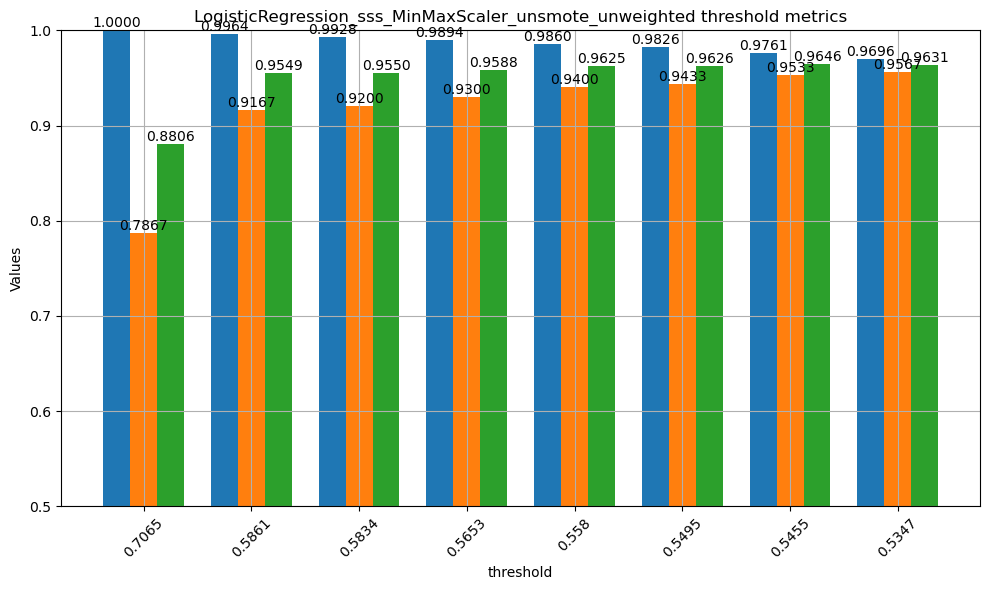

In [395]:
plot_bar_graphs(diff_dc['LogisticRegression_sss_MinMaxScaler_unsmote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='LogisticRegression_sss_MinMaxScaler_unsmote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

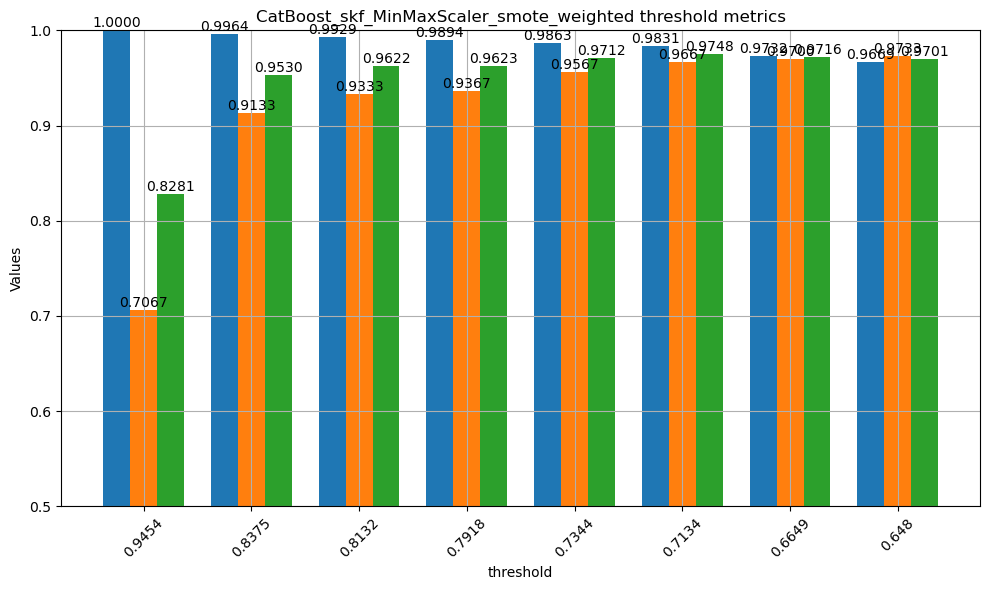

In [399]:
plot_bar_graphs(diff_dc['CatBoost_skf_MinMaxScaler_smote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_skf_MinMaxScaler_smote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

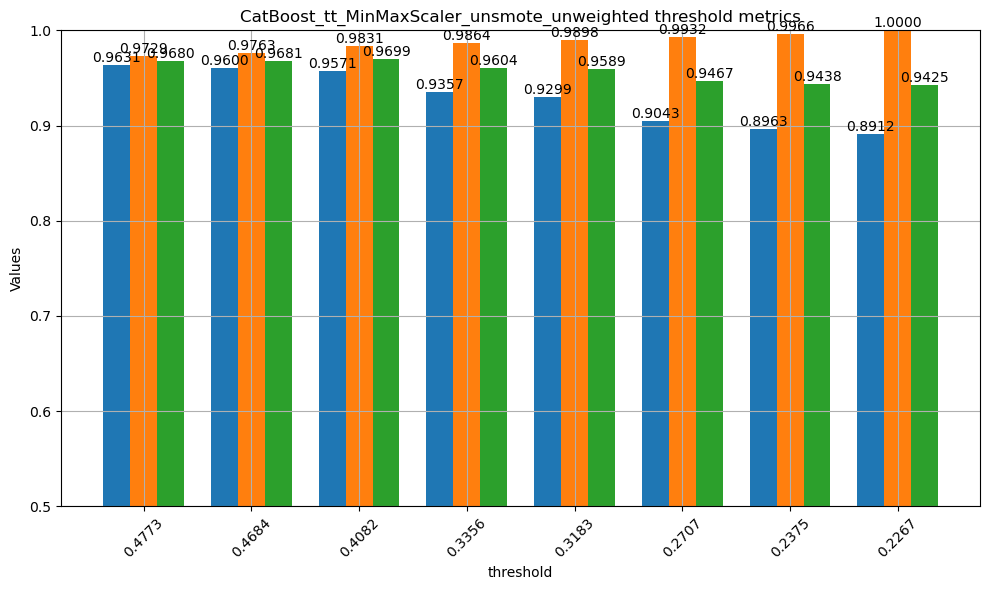

In [452]:
plot_bar_graphs(diff_dc['CatBoost_tt_MinMaxScaler_unsmote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='CatBoost_tt_MinMaxScaler_unsmote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

In [451]:
r_prec = pd.DataFrame(list(perfect_recall.items()), columns=['index', 'max_f1']).set_index('index')
r_prec.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
CatBoost_tt_MinMaxScaler_unsmote_unweighted,0.942492
CatBoost_tt_MaxAbsScaler_unsmote_unweighted,0.942492
CatBoost_tt_StandardScaler_unsmote_unweighted,0.942492
CatBoost_tt_MinMaxScaler_smote_weighted,0.940989
CatBoost_tt_StandardScaler_smote_weighted,0.940989
CatBoost_tt_MaxAbsScaler_smote_weighted,0.940989
LGBM_skf_MinMaxScaler_unsmote_weighted,0.938967
LGBM_skf_StandardScaler_unsmote_weighted,0.938967
LGBM_skf_MinMaxScaler_unsmote_unweighted,0.938967


In [84]:
p_prec = pd.DataFrame(list(perfect_precision.items()), columns=['index', 'max_f1']).set_index('index')
p_prec.sort_values(by='max_f1',ascending=False).head(15)

,max_f1
index,
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.928571
LogisticRegression_sss_MaxAbsScaler_smote_weighted,0.928571
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.928571
CatBoost_skf_MaxAbsScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.911071
CatBoost_skf_StandardScaler_unsmote_weighted,0.911071
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.905109
CatBoost_skf_StandardScaler_unsmote_unweighted,0.905109


# 100% Precision

In [85]:
top_prec = ['CatBoost_skf_MaxAbsScaler_unsmote_weighted', 'LogisticRegression_sss_MinMaxScaler_smote_weighted', 
           'CatBoost_skf_MinMaxScaler_unsmote_unweighted', 'LGBM_sss_MinMaxScaler_unsmote_weighted',
           ]

In [276]:
tops_df.sort_values(by='recall_at_precision_1', ascending=False)[['recall_at_precision_1','optimal_threshold', 'max_f1_score']].head(15)

,recall_at_precision_1,optimal_threshold,max_f1_score
model,,,
LogisticRegression_sss_MinMaxScaler_smote_weighted,0.866667,0.740441,0.952381
LogisticRegression_sss_MaxAbsScaler_smote_unweighted,0.866667,0.740442,0.952381
LogisticRegression_sss_MaxAbsScaler_smote_weighted,0.866667,0.740442,0.952381
LogisticRegression_sss_MinMaxScaler_smote_unweighted,0.866667,0.740441,0.952381
CatBoost_skf_MaxAbsScaler_unsmote_weighted,0.836667,0.429214,0.971993
CatBoost_skf_MinMaxScaler_unsmote_weighted,0.836667,0.429214,0.971993
CatBoost_skf_StandardScaler_unsmote_weighted,0.836667,0.429214,0.971993
CatBoost_skf_MinMaxScaler_unsmote_unweighted,0.826667,0.400109,0.971901
CatBoost_skf_StandardScaler_unsmote_unweighted,0.826667,0.400109,0.971901


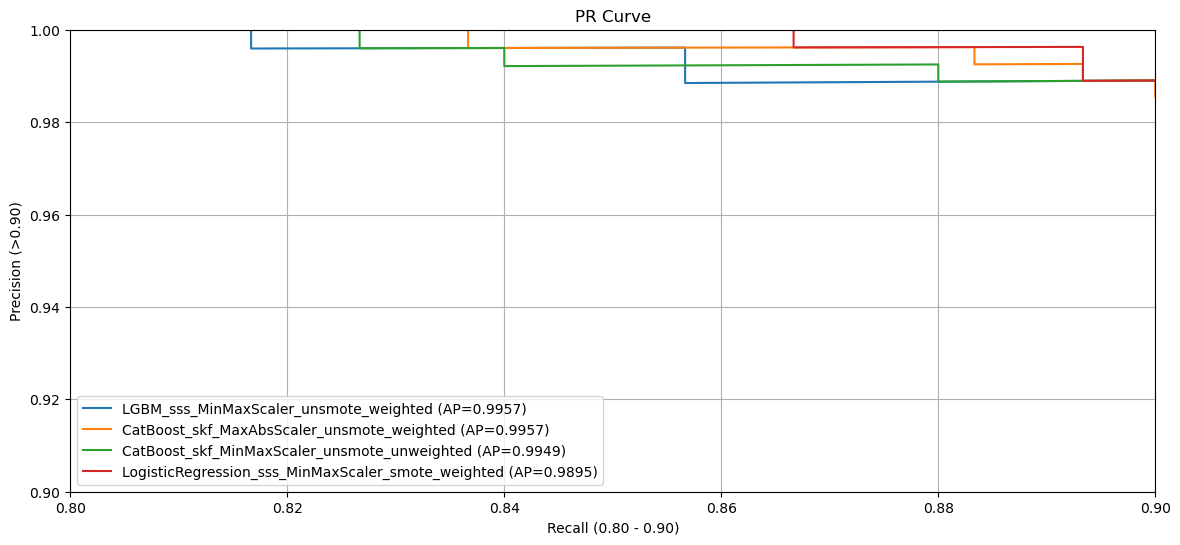

In [274]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(top_prec)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.8, x_max=0.9, y_min=0.90, label=idx, xlab = 'Recall (0.80 - 0.90)', ylab='Precision (>0.90)', title='PR Curve')
    
plt.show()

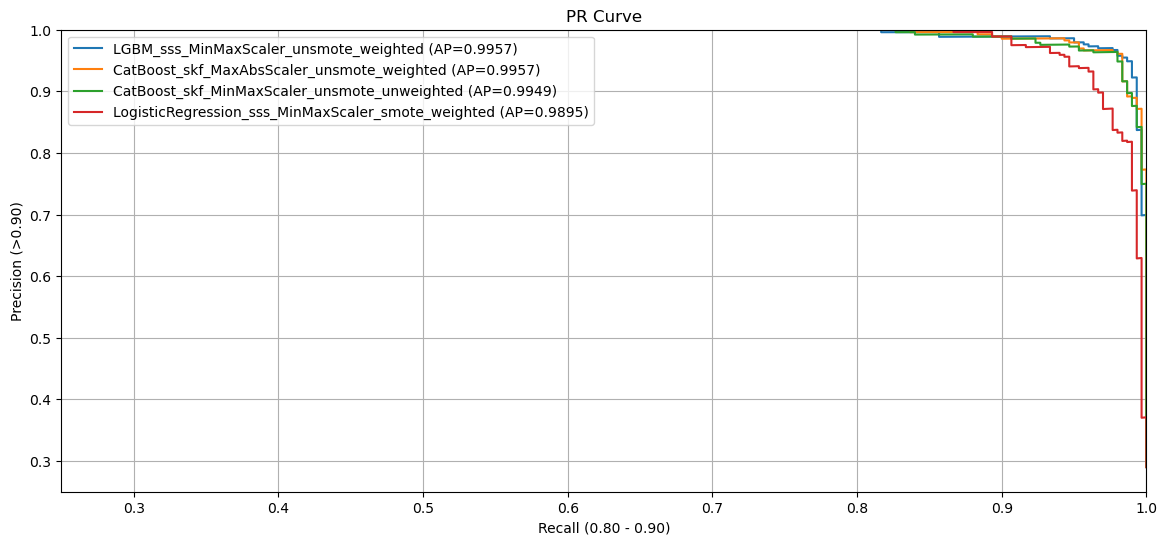

In [280]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(top_prec)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.25, x_max=1, y_min=0.25, y_max=1, label=idx, xlab = 'Recall (0.80 - 0.90)', ylab='Precision (>0.90)', title='PR Curve')
    
plt.show()

# Top f1

In [123]:
f1s = ['LGBM_skf_StandardScaler_smote_weighted', 'CatBoost_sss_StandardScaler_unsmote_weighted',
      'LGBM_skf_MinMaxScaler_smote_weighted', 'CatBoost_skf_StandardScaler_smote_weighted']

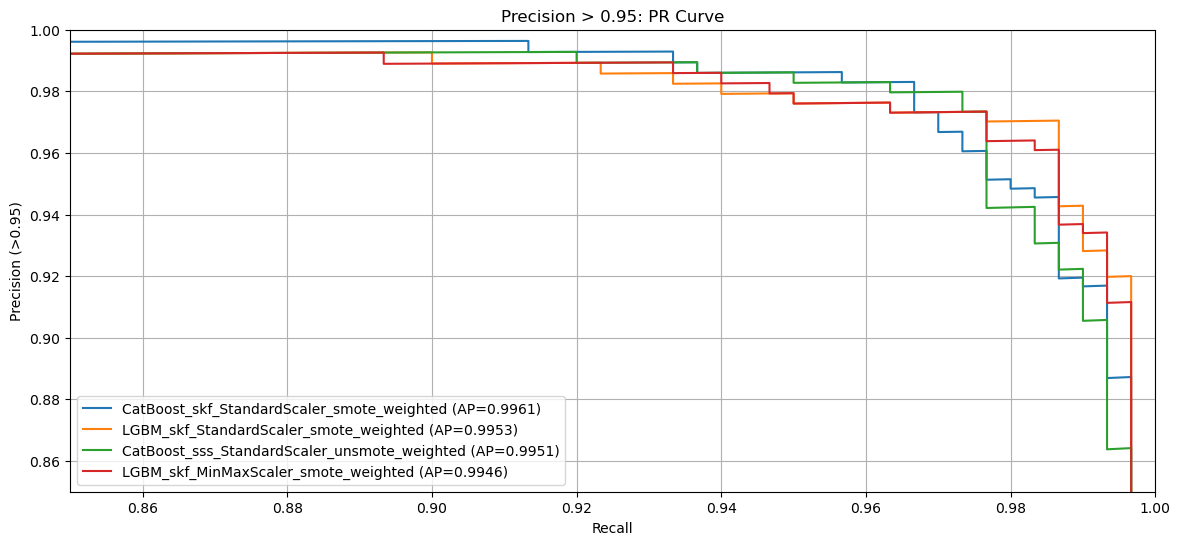

In [125]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(fones)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.85, x_max=1, y_min=0.85, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

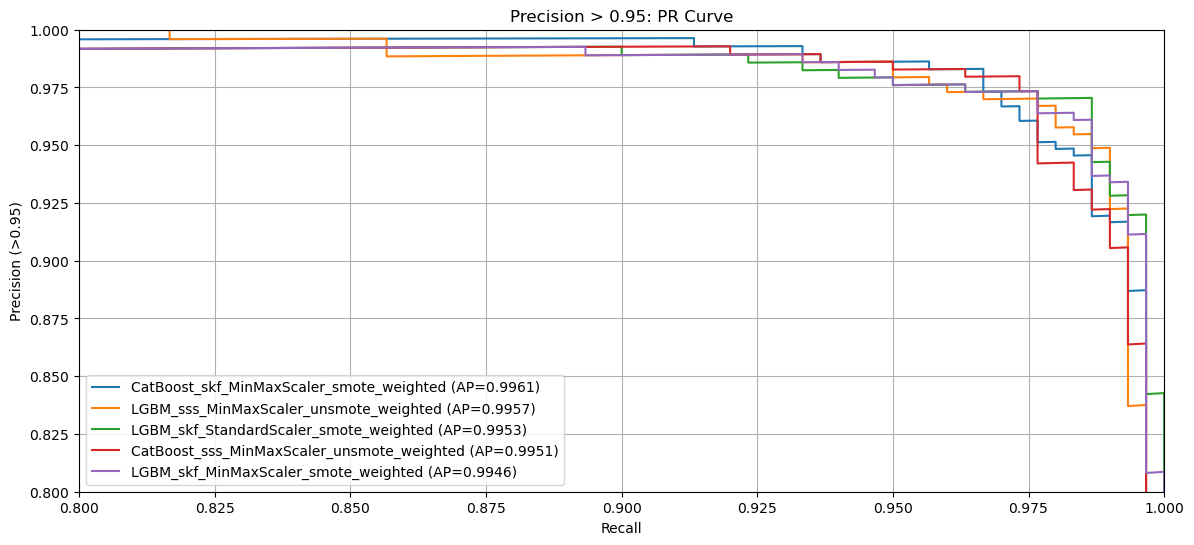

In [382]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(fones)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.8, x_max=1, y_min=0.8, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

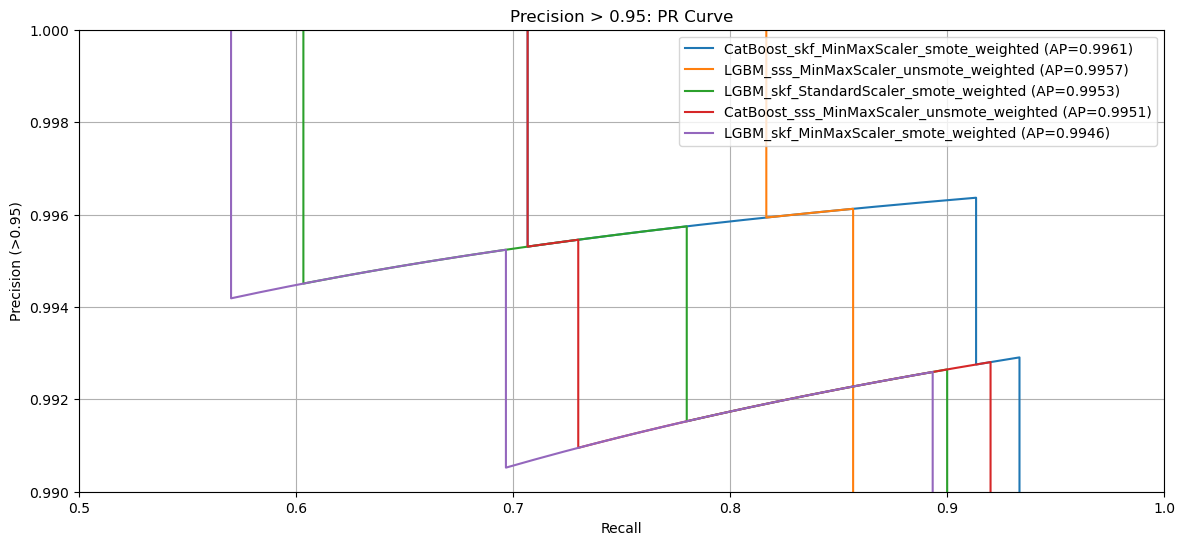

In [378]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(fones)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.5, x_max=1, y_min=0.99, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

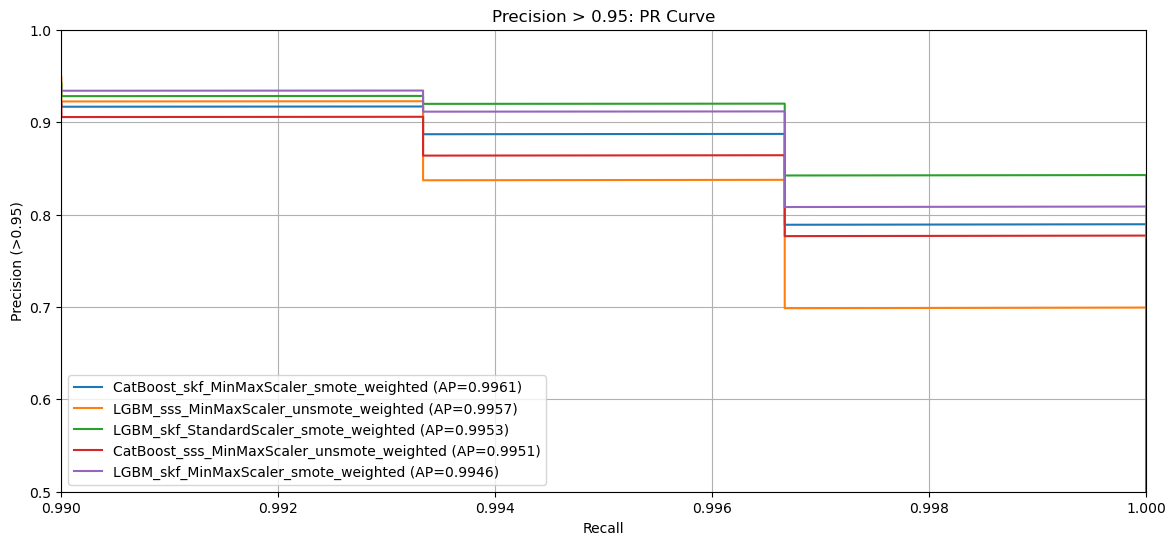

In [379]:
plt.figure(figsize=(14, 6)) 

for idx, row in results_df[results_df.index.isin(fones)].sort_values(by='average_precision_class_1', ascending=False).iterrows():
    if type(row['precision_recall_class_1']) == str:
        pr = string_array_split(row['precision_recall_class_1'])
    else:
        pr = row['precision_recall_class_1']
    ap = row['average_precision_class_1']
    plot_pr_curve(pr, ap,x_min=0.99, x_max=1, y_min=0.5, label=idx, ylab='Precision (>0.95)', title='Precision > 0.95: PR Curve')
    
plt.show()

In [289]:
tops_df.loc[[x for x in tops_df.index if 'RandomF' in x]].sort_values(by='precision_at_recall_1', ascending=False)[['max_f1_score','optimal_threshold']].head(10)

,max_f1_score,optimal_threshold
model,,
RandomForest150_tt_MinMaxScaler_smote_unweighted,0.959350,0.493333
RandomForest150_tt_MinMaxScaler_smote_weighted,0.958264,0.546667
RandomForest150_tt_MinMaxScaler_unsmote_unweighted,0.969900,0.486667
RandomForest150_tt_MaxAbsScaler_unsmote_weighted,0.965058,0.480000
RandomForest150_tt_MaxAbsScaler_smote_unweighted,0.961857,0.513333
RandomForest150_tt_StandardScaler_unsmote_unweighted,0.959596,0.493333
RandomForest150_tt_StandardScaler_smote_weighted,0.960526,0.513333
RandomForest150_tt_MaxAbsScaler_smote_weighted,0.956522,0.553333
RandomForest150_tt_StandardScaler_smote_unweighted,0.961730,0.546667


In [ ]:
['RandomForest150_tt_MinMaxScaler_unsmote_unweighted']

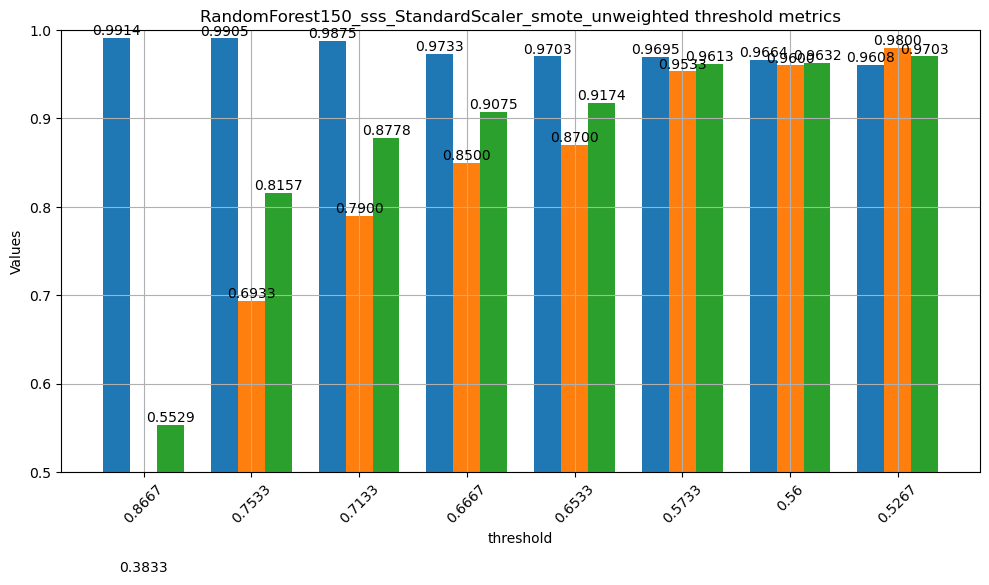

In [288]:
plot_bar_graphs(diff_dc['RandomForest150_sss_StandardScaler_smote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='RandomForest150_sss_StandardScaler_smote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

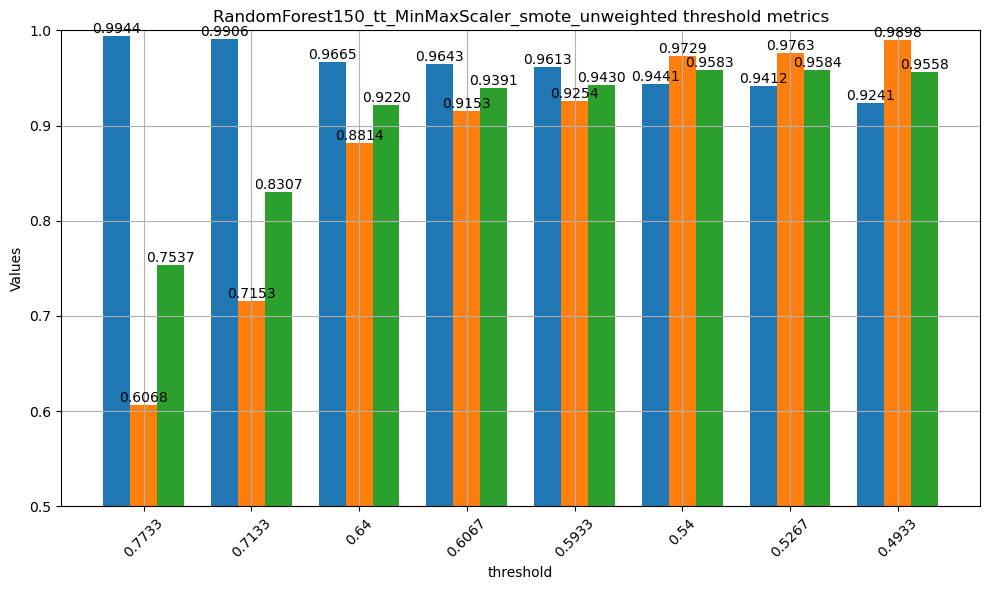

In [287]:
plot_bar_graphs(diff_dc['RandomForest150_tt_MinMaxScaler_smote_unweighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='RandomForest150_tt_MinMaxScaler_smote_unweighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

In [362]:
tops_df.loc[[x for x in tops_df.index if 'RandomF' in x]].sort_values(by='max_f1_score', ascending=False)[['recall_at_precision_1','max_f1_score','optimal_threshold']].head(10)

,recall_at_precision_1,max_f1_score,optimal_threshold
model,,,
RandomForest150_sss_StandardScaler_smote_unweighted,0.233333,0.970395,0.526667
RandomForest150_skf_MaxAbsScaler_smote_unweighted,0.713333,0.970395,0.540000
RandomForest150_tt_MinMaxScaler_unsmote_unweighted,0.359322,0.969900,0.486667
RandomForest150_sss_MinMaxScaler_smote_unweighted,0.136667,0.969106,0.520000
RandomForest150_skf_MinMaxScaler_smote_unweighted,0.620000,0.968801,0.520000
RandomForest150_sss_MinMaxScaler_unsmote_weighted,0.456667,0.967427,0.446667
RandomForest150_sss_MinMaxScaler_smote_weighted,0.130000,0.967320,0.520000
RandomForest150_skf_MaxAbsScaler_smote_weighted,0.530000,0.967105,0.546667
RandomForest150_tt_StandardScaler_unsmote_weighted,0.430508,0.966997,0.446667


In [368]:
tops_df.sort_values(by='max_f1_score', ascending=False)[['max_f1_score','recall_at_precision_1', 'precision_at_recall_1', 'optimal_threshold']].head(25)

,max_f1_score,recall_at_precision_1,precision_at_recall_1,optimal_threshold
model,,,,
LGBM_skf_StandardScaler_smote_weighted,0.978512,0.603333,0.842697,0.573696
LGBM_skf_StandardScaler_smote_unweighted,0.978512,0.603333,0.842697,0.573696
CatBoost_sss_MinMaxScaler_unsmote_weighted,0.976589,0.706667,0.777202,0.556067
CatBoost_sss_MaxAbsScaler_unsmote_weighted,0.976589,0.706667,0.777202,0.556067
CatBoost_sss_StandardScaler_unsmote_weighted,0.976589,0.706667,0.777202,0.556067
LGBM_skf_MaxAbsScaler_smote_unweighted,0.975042,0.570000,0.808625,0.655214
LGBM_skf_MaxAbsScaler_smote_weighted,0.975042,0.570000,0.808625,0.655214
LGBM_skf_MinMaxScaler_smote_unweighted,0.975042,0.570000,0.808625,0.655214
LGBM_skf_MinMaxScaler_smote_weighted,0.975042,0.570000,0.808625,0.655214


In [370]:
fones = tops_df.drop_duplicates().sort_values(by='max_f1_score', ascending=False)[['max_f1_score','recall_at_precision_1', 'precision_at_recall_1', 'optimal_threshold']].head(5).index

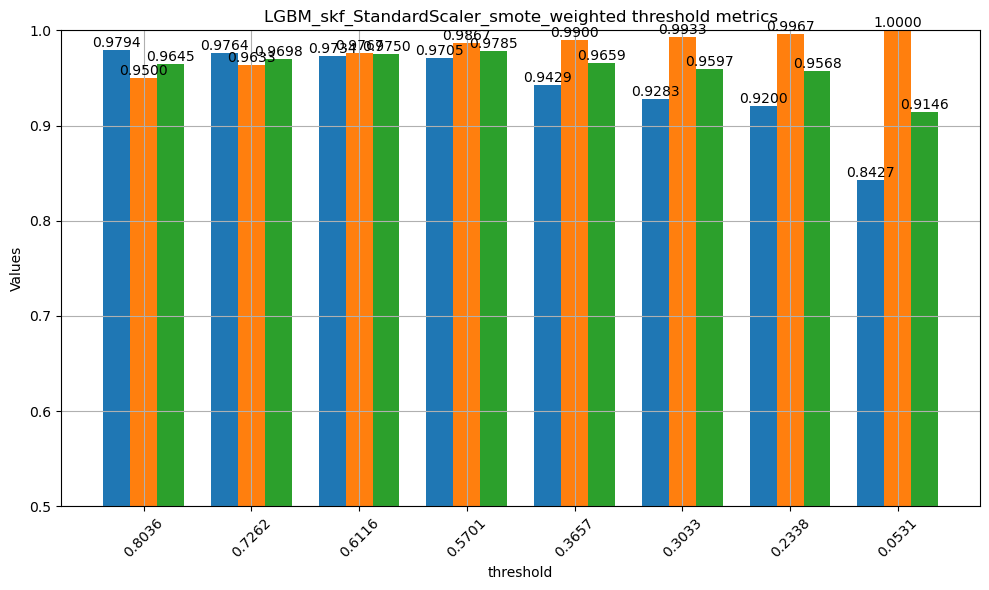

In [646]:
plot_bar_graphs(diff_dc['LGBM_skf_StandardScaler_smote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='LGBM_skf_StandardScaler_smote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

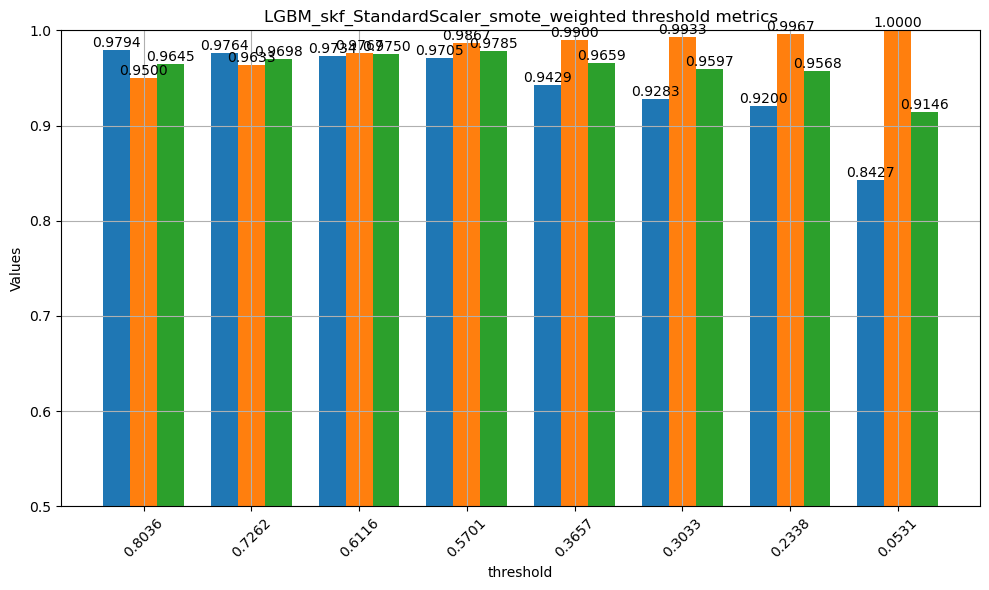

In [121]:
plot_bar_graphs(diff_dc['CatBoost_sss_MinMaxScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(8), 
['precision','recall','f1'], title ='CatBoost_sss_MinMaxScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

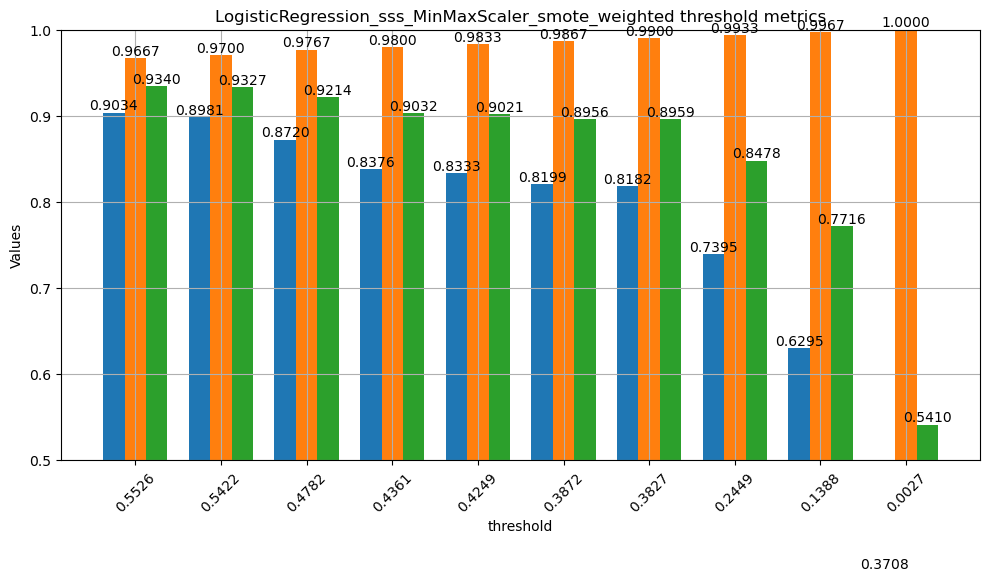

In [406]:
plot_bar_graphs(diff_dc['LogisticRegression_sss_MinMaxScaler_smote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(10), 
['precision','recall','f1'], title ='LogisticRegression_sss_MinMaxScaler_smote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(10,6), legend=False)

In [417]:
train_df.loc['LogisticRegression_sss_MinMaxScaler_smote_weighted']

accuracy                                                              0.975315
precision                                                             0.953836
recall                                                                0.998979
f1                                                                    0.975886
roc_auc                                                               0.999455
tp                                                                        2934
tn                                                                        2795
fp                                                                         142
fn                                                                           3
precision_recall             ([0.5, 0.5000851353652307, 0.5001702997275205,...
average_precision                                                     0.999425
roc_curve                    ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
precision_recall_class_0     ([0.5, 0.50008513536523

In [418]:
results_df.loc['LogisticRegression_sss_MinMaxScaler_smote_weighted']

accuracy                                                              0.951691
precision                                                             0.872024
recall                                                                0.976667
f1                                                                    0.921384
roc_auc                                                               0.993605
tp                                                                         293
tn                                                                         692
fp                                                                          43
fn                                                                           7
precision_recall_class_1     ([0.2898550724637681, 0.2901353965183752, 0.29...
average_precision_class_1                                             0.989452
roc_curve_class_1            ([0.0, 0.0, 0.0, 0.0, 0.0, 0.00136054421768707...
roc_auc_class_1                                     

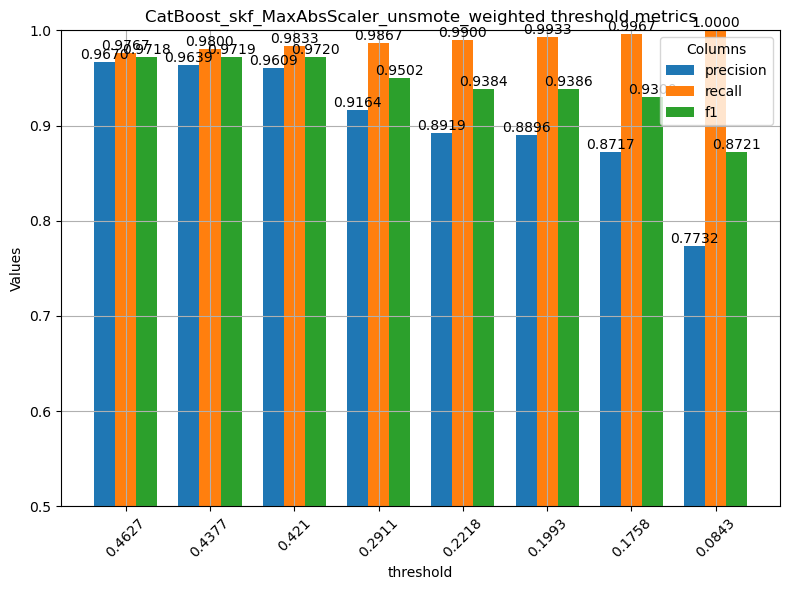

In [136]:
plot_bar_graphs(diff_dc['CatBoost_skf_MaxAbsScaler_unsmote_weighted'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).tail(8), 
['precision','recall','f1'], title ='CatBoost_skf_MaxAbsScaler_unsmote_weighted threshold metrics', horizontal=False, decimal=4, bar_min=0.5, figsize=(8,6))

{'CatBoost_sss_MinMaxScaler_unsmote_unweighted': 0.9586206896052317,
 'CatBoost_sss_StandardScaler_unsmote_unweighted': 0.9586206896052317,
 'CatBoost_sss_MaxAbsScaler_unsmote_unweighted': 0.9586206896052317,
 'RandomForest150_sss_MinMaxScaler_unsmote_weighted': 0.9328621907629012,
 'RandomForest150_sss_MinMaxScaler_unsmote_unweighted': 0.9136690646985146,
 'CatBoost_skf_MinMaxScaler_unsmote_unweighted': 0.9328621907629012,
 'CatBoost_skf_StandardScaler_unsmote_unweighted': 0.9328621907629012,
 'CatBoost_skf_MaxAbsScaler_unsmote_unweighted': 0.9328621907629012,
 'CatBoost_sss_MinMaxScaler_unsmote_weighted': 0.9550173009881349,
 'CatBoost_sss_StandardScaler_unsmote_weighted': 0.9550173009881349,
 'CatBoost_sss_MaxAbsScaler_unsmote_weighted': 0.9550173009881349,
 'RandomForest150_skf_MinMaxScaler_unsmote_unweighted': 0.8118811880705813,
 'CatBoost_skf_MinMaxScaler_unsmote_weighted': 0.9403508771431208,
 'CatBoost_skf_StandardScaler_unsmote_weighted': 0.9403508771431208,
 'CatBoost_skf_Ma

In [30]:
import re

def string_array_split(s):
    pattern = r'array\(\[(.*?)\]\)'
    matches = re.findall(pattern, s, re.DOTALL)

    arrays = []
    for match in matches:
        clean_match = match.replace('\n', '').replace(' ', '')

        try:
            number_list = [float(num) for num in clean_match.split(',') if num]
            array = np.array(number_list)
            arrays.append(array)
        except ValueError as e:
            print(f"Error converting to array: {e}")

    return arrays


In [31]:
import matplotlib.pyplot as plt

def plot_two_bar_graphs(df1, df2, columns, labels=['df1', 'df2'], title='Model Performance Comparison', x_label=None, y_label='Values',
                        horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, grid=True, decimal=3,
                        group_spacing=0.1, bar_width=0.3):
    if x_label is None:
        x_label = 'Index'
    
    num_cols = len(columns)
    width = bar_width / 2  # Adjust width for two sets of bars
    x = range(len(df1))  # X positions for bars based on number of indices

    # Adjust spacing between groups
    group_width = width * 2 + group_spacing
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    legend_labels = [labels[0], labels[1]]  # Legend only shows dataset names

    if horizontal:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.barh([p + offset - width / 2 for p in x], df1[col], height=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.barh([p + offset + width / 2 for p in x], df2[col], height=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        # Plot bars for both DataFrames
        for i, col in enumerate(columns):
            if col in df1.columns and col in df2.columns:
                offset = group_width * i
                bars1 = plt.bar([p + offset - width / 2 for p in x], df1[col], width=width, color='#1f77b4', label=labels[0])  # Dark Blue
                bars2 = plt.bar([p + offset + width / 2 for p in x], df2[col], width=width, color='#ff7f0e', label=labels[1])  # Dark Orange
                
                # Collect handles
                handles.extend([bars1[0], bars2[0]])
                
                for bar in bars1:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

                for bar in bars2:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)
                
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p + group_width * (num_cols - 1) / 2 for p in x], labels=df1.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        plt.legend(handles=handles, labels=legend_labels, title='Datasets')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [32]:
def df_to_diff_dc(df):
    pr_curve_dc = {}
    precision_drop_dc = {}

    for idx, row in df.iterrows():
        pr_curve_dc[idx] = create_pr_df(row)[0]
        precision_drop_dc[idx] = create_pr_df(row)[1]

    diffs = create_diff_within(precision_drop_dc)  
    return diffs

In [33]:
def create_diff_within(dc):
    for k,v in dc.items():
        v['precision_diff'] = v['precision'].diff().fillna(0)
        v['recall_diff'] = v['recall'].diff().fillna(0)
        v['f1'] = 2 * (v['precision'] * v['recall']) / (v['precision'] + v['recall'] + 1e-10) 
        v['threshold'] = round(v['threshold'],4)
        v = v.reset_index(drop=True).set_index('threshold')
    return dc

In [34]:
def create_pr_df(row):

    if type(row['precision_recall_class_1']) == str:
        cb_p, cb_r, cb_th = string_array_split(row['precision_recall_class_1'])
    else:
        cb_p, cb_r, cb_th = row['precision_recall_class_1']
        
    #cb_p, cb_r, cb_th = string_array_split(row['precision_recall'])
    
    cb_r = cb_r
    cb_p = cb_p
    cb_th = np.append(0, cb_th)

    cb_pr_df = pd.DataFrame({
    'threshold': cb_th,
    'precision': cb_p,
    'recall': cb_r
    })
    
    return cb_pr_df, cb_pr_df[cb_pr_df.index.isin(find_drops(cb_p))].sort_values(by='precision', ascending=False)

In [35]:
def find_drops(y):
  
    diffs = np.diff(y)
    
    return np.where(np.diff(np.sign(diffs)) < 0)[0] + 1


In [36]:
import matplotlib.pyplot as plt

def plot_bar_graphs(df, columns, title='Model Performance Comparison', x_label=None, y_label='Values', 
                     horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, 
                     grid=True, decimal=3, bar_width=0.75):
    if x_label is None:
        x_label = df.index.name if df.index.name is not None else 'Index'

    num_cols = len(columns)
    width = bar_width / num_cols  # Use the bar_width parameter
    x = range(len(df))
    
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    labels = []
    
    if horizontal:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.barh([p + offset for p in x], df[col], height=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height() / 2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + width * ((num_cols - 1) / 2) for p in x], labels=df.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.bar([p + offset for p in x], df[col], width=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_x() + bar.get_width() / 2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=[p for p in x], labels=df.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        # Reverse the order of handles and labels if the plot is horizontal
        if horizontal:
            handles = handles[::-1]
            labels = labels[::-1]
        plt.legend(handles=handles, labels=labels, title='Columns')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()


In [565]:
def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve', x_min=0, x_max = 0.125, y_min=0.875, y_max=1.0, label=None):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')


In [38]:
def plot_pr_curve(precision_recall, average_precision, title='Precision-Recall Curve', x_min=0.75, x_max=1.0, y_min=0.75, y_max=1, xlab='Recall', ylab='Precision',label=None):

    precision, recall, _ = precision_recall

    plt.plot(recall, precision, label=f'{label} (AP={average_precision:.4f})')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)


In [39]:
def rp_curve(df, idx):

    p_arr = df.loc[idx,'precision_recall'][0]
    r_arr = df.loc[idx,'precision_recall'][1]
    th_arr = df.loc[idx,'precision_recall'][2]
    avg_r = np.mean(r_arr)
    plot_pr_curve((r_arr,p_arr,th_arr), avg_r, title='Initial Precision Drops', x_min=0.75,x_max=1, y_min=0.75, label=idx)